In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import rasterio
from rasterio.plot import reshape_as_raster, reshape_as_image

import tensorflow

from deepforest import deepforest

import matplotlib.pylab as plt
import ot
import ot.plot
import cv2

from sklearn.metrics import accuracy_score

/anaconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

In [2]:
import sys
package = os.path.dirname(os.getcwd())
sys.path.append(package)
sys.path.append(package + '/utils')
sys.path

['/anaconda3/envs/venv/lib/python36.zip',
 '/anaconda3/envs/venv/lib/python3.6',
 '/anaconda3/envs/venv/lib/python3.6/lib-dynload',
 '',
 '/Users/kenzaamara/.local/lib/python3.6/site-packages',
 '/anaconda3/envs/venv/lib/python3.6/site-packages',
 '/anaconda3/envs/venv/lib/python3.6/site-packages/IPython/extensions',
 '/Users/kenzaamara/.ipython',
 '/Users/kenzaamara/Documents/ETH Zurich/Master/Master Thesis/code/oneforest',
 '/Users/kenzaamara/Documents/ETH Zurich/Master/Master Thesis/code/oneforest/utils']

In [3]:
import utils 

from utils.citizen_science import *
from utils.extract_features import *

from utils.deepforest_detection import *
from utils.deepforest_evaluation import *

from utils.visualisation import *
from utils.plot_folium import *
from utils.plot_density import *

from utils.mapping import *

In [4]:
def index_nn(X_ground_nn, X_drone_nn):
    
    n = len(X_ground_nn)
    m = len(X_drone_nn)
    X = np.concatenate([X_ground_nn, X_drone_nn])
    
    dists, idxs = nearest_neighbors(X, nbr_neighbors=n+m)

    ground_index = []
    for i in range(n):
        p = 1
        id = X[i,2]
        while(X[idxs[i][p], 2] == id):
            p += 1
        j = idxs[i,p]
        ground_index.append(j-n)
    ground_index = np.array(ground_index, dtype = np.int32)
    return(ground_index)

# Simulate Increasing Random Noise

## Evaluate Matching Methods on Ecuador

In [273]:
boxes

img_path  xmin  ymin  xmax  ymax label  \
0    Flora Pluas RGB_7_3800_7600_7800_11600.png  1296  3662  1838  4000  Tree   
1    Flora Pluas RGB_7_3800_7600_7800_11600.png  1418  2006  1779  2324  Tree   
2    Flora Pluas RGB_7_3800_7600_7800_11600.png  2770  3578  3022  3793  Tree   
3    Flora Pluas RGB_7_3800_7600_7800_11600.png  2553  3053  2944  3384  Tree   
4    Flora Pluas RGB_7_3800_7600_7800_11600.png   148  3849   683  3996  Tree   
..                                          ...   ...   ...   ...   ...   ...   
100  Flora Pluas RGB_7_3800_7600_7800_11600.png  1106  2213  1666  2699  Tree   
101  Flora Pluas RGB_7_3800_7600_7800_11600.png   440  1625  1159  2431  Tree   
102  Flora Pluas RGB_7_3800_7600_7800_11600.png  1781  1559  2418  2145  Tree   
103  Flora Pluas RGB_7_3800_7600_7800_11600.png  1167  1292  1755  1941  Tree   
104  Flora Pluas RGB_7_3800_7600_7800_11600.png   557   441  1365  1214  Tree   

     is_musacea       x       y  
0             0  1567.0  3831.0  
1             1  1598.5  2165.0  
2             1  2896.0  3685.5  
3             1  2748.5  3218.5  
4             1   415.5  3922.5  
..          ...     ...     ...  
100           1  1386.0  2456.0  
101           1   799.5  2028.0  
102           1  2099.5  1852.0  
103           1  1461.0  1616.5  
104           1   961.0   827.5  

[105 rows x 9 columns]

In [219]:
site_data = pd.read_csv('Ecuador/features/ortho_data.csv')

rx_meters = []
ry_meters = []

for index, row in site_data.iterrows():
    height_pxl = (row.lat_max - row.lat_min)/row.ratio_y
    length_pxl = (row.lon_max - row.lon_min)/row.ratio_x
    
    coords_1 = (row.lat_min, row.lon_min)
    coords_2 = (row.lat_max, row.lon_min)

    height = geopy.distance.vincenty(coords_1, coords_2).km*1000

    coords_1 = (row.lat_min, row.lon_min)
    coords_2 = (row.lat_min, row.lon_max)

    length = geopy.distance.vincenty(coords_1, coords_2).km*1000
    
    rx_meters.append(length_pxl/length)
    ry_meters.append(height_pxl/height)
    
print(np.mean(rx_meters))
print(np.mean(ry_meters))

# 1 meter is represented by approximatively 160 pixels

160.2088739351711
154.29054259676352


/anaconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  del sys.path[0]
/anaconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.


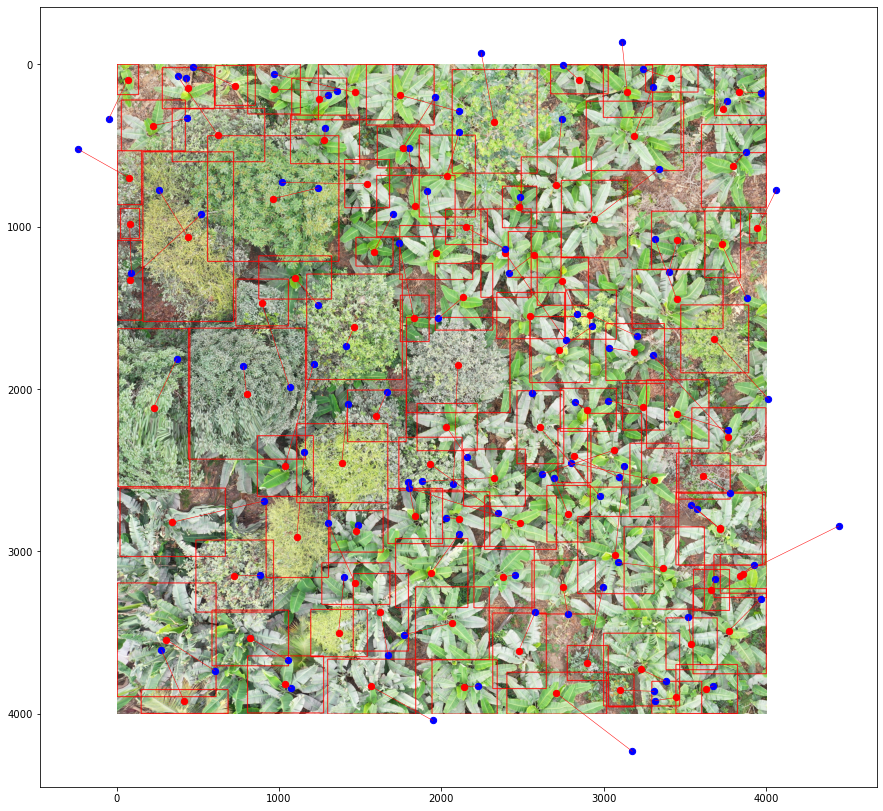

In [234]:
img_path = 'Ecuador/evaluation/test_example.tif'
im = cv2.imread(img_path)
annot = box_to_annotation(boxes[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy())
im = draw_annotations(im, annot, color=(0, 0, 255), label_to_name=None, plot = False, cv2_authorized = False, thickness = 4)

n = len(X_d)
for k in range(len(sigmas)):
    noise = np.random.normal(0, sigmas[k], (n, 2))
    X_ground = X_g + noise
    X_drone = X_d
    
    
    plt.figure(figsize=(15,15))
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

    for i in range(n):
        plt.scatter(x=X_ground[i][0], y=X_ground[i][1], c='b', s=40)
        plt.scatter(x=X_drone[i][0], y=X_drone[i][1], c='r', s=40)

        plt.plot([X_ground[i][0], X_drone[i][0]], [X_ground[i][1], X_drone[i][1]], color='red', marker=None, linewidth=0.5, markersize=2)
    plt.show()

In [235]:
def plot_mapping(X_drone, X_ground, idx):

    img_path = 'Ecuador/evaluation/test_example.tif'
    im = cv2.imread(img_path)
    annot = box_to_annotation(boxes[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy())
    im = draw_annotations(im, annot, color=(0, 0, 255), label_to_name=None, plot = False, cv2_authorized = False, thickness = 4)

    plt.figure(figsize=(15,15))
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

    X_drone_pred = X_drone[idx]
    print(idx)
    n = len(X_ground)
    y_true = range(n)
    res = y_true == idx
    print(res)

    for i in range(n):
        plt.scatter(x=X_ground[i][0], y=X_ground[i][1], c='b', s=40)
        plt.scatter(x=X_drone[i][0], y=X_drone[i][1], c='r', s=40)

        #plt.plot([X_ground[i][0], X_drone[i][0]], [X_ground[i][1], X_drone[i][1]], color='red', marker="o", linewidth=0.5, markersize=2)
        
        if res[i] == True:
            plt.plot([X_ground[i][0], X_drone_pred[i][0]], [X_ground[i][1], X_drone_pred[i][1]], color='green', marker=None, linewidth=1)
        if res[i] == False:
            plt.plot([X_ground[i][0], X_drone_pred[i][0]], [X_ground[i][1], X_drone_pred[i][1]], color='red', marker=None, linewidth=1)

    plt.show()

In [348]:
def evaluation_noise(sigmas, X_d, mus_d=None, mus_g=None):
    
    Acc_nn = []
    Acc_ot_non_greedy = []
    Acc_ot_greedy = []
    Acc_ot_cnn = []
    Acc_gw = []
    

    n = len(X_d)
    for k in range(len(sigmas)):
        sigma = sigmas[k]
        noise = np.random.normal(0, sigma, (n, 2))
        X_ground = X_d + noise
        X_drone = X_d
        
        y_true = range(n)

        # Nearest Neighbours
        X_drone_nn = np.hstack((X_drone, np.zeros((n, 1), dtype=np.int32)))
        X_ground_nn = np.hstack((X_ground, np.zeros((n, 1), dtype=np.int32)+1))
        idx = index_nn(X_ground_nn, X_drone_nn)
        Acc_nn.append(accuracy_score(y_true, idx))
        #plot_mapping(X_drone, X_ground, idx)

        # OT ground to drone
        G = OT_sinkhorn(X_drone, X_ground, lambd = 0.01)
        idx = np.argmax(G, axis = 0)
        Acc_ot_non_greedy.append(accuracy_score(y_true, idx))
        #plot_mapping(X_drone, X_ground, idx)
        
        # OT greedy
        G = OT_sinkhorn(X_drone, X_ground, lambd = 0.01)
        cost = -G*10e4
        row_ind, col_ind = linear_sum_assignment(cost)
        Acc_ot_greedy.append(accuracy_score(y_true, col_ind))
        #plot_mapping_inv(X_drone, X_ground, idx)
        
        
        if mus_g is not None:
            # OT with CNN filtering ground to drone
            G = OT_scores_sinkhorn(X_drone, X_ground, mus_d, mus_g, mu = 1, lambd = 0.01)
            cost = -G
            row_ind, col_ind = linear_sum_assignment(cost)
            Acc_ot_cnn.append(accuracy_score(y_true, col_ind))
        
        
        # Gromov-Wasserstein
        G = gromov_wasserstein(X_drone, X_ground)
        idx = np.argmax(G, axis = 0)
        Acc_gw.append(accuracy_score(y_true, idx))
        
        
    return(Acc_nn, Acc_ot_non_greedy, Acc_ot_greedy, Acc_ot_cnn, Acc_gw)

In [257]:
def evaluation_shift(shifts, X_d, mus_d=None, mus_g=None):
    
    Acc_nn = []
    Acc_ot_non_greedy = []
    Acc_ot_greedy = []
    Acc_ot_cnn = []
    Acc_gw = []
    

    n = len(X_d)
    for k in range(len(shifts)):
        shift = shifts[k]
        X_ground = X_d + shift
        X_drone = X_d
        
        y_true = range(n)

        # Nearest Neighbours
        X_drone_nn = np.hstack((X_drone, np.zeros((n, 1), dtype=np.int32)))
        X_ground_nn = np.hstack((X_ground, np.zeros((n, 1), dtype=np.int32)+1))
        idx = index_nn(X_ground_nn, X_drone_nn)
        Acc_nn.append(accuracy_score(y_true, idx))
        #plot_mapping(X_drone, X_ground, idx)

        # OT ground to drone
        G = OT_sinkhorn(X_drone, X_ground, lambd = 0.01)
        idx = np.argmax(G, axis = 0)
        Acc_ot_non_greedy.append(accuracy_score(y_true, idx))
        #plot_mapping(X_drone, X_ground, idx)
        
        # OT greedy
        G = OT_sinkhorn(X_drone, X_ground, lambd = 0.01)
        cost = -G*10e4
        row_ind, col_ind = linear_sum_assignment(cost)
        Acc_ot_greedy.append(accuracy_score(y_true, col_ind))
        #plot_mapping_inv(X_drone, X_ground, idx)
        
        
        if mus_g is not None:
            # OT with CNN filtering ground to drone
            G = OT_scores_sinkhorn(X_drone, X_ground, mus_d, mus_g, mu = 1, lambd = 0.01)
            cost = -G
            row_ind, col_ind = linear_sum_assignment(cost)
            Acc_ot_cnn.append(accuracy_score(y_true, col_ind))
        
        
        # Gromov-Wasserstein
        G = gromov_wasserstein(X_drone, X_ground)
        idx = np.argmax(G, axis = 0)
        Acc_gw.append(accuracy_score(y_true, idx))
        
        
    return(Acc_nn, Acc_ot_non_greedy, Acc_ot_greedy, Acc_ot_cnn, Acc_gw)


In [343]:
df = pd.read_csv('Ecuador/annotations/final_annotations.csv', index_col = 0)
df.columns

Index(['img_path', 'xmin', 'ymin', 'xmax', 'ymax', 'score', 'img_name',
       'tile_index', 'tile_xmin', 'tile_ymin', 'tile_xmax', 'tile_ymax', 'x',
       'y', 'Xmin', 'Ymin', 'Xmax', 'Ymax', 'X', 'Y', 'lon', 'lat',
       'is_musacea'],
      dtype='object')

In [344]:
df = pd.read_csv('Ecuador/evaluation/hand_test_example.csv', names = ['img_path', 'xmin', 'ymin', 'xmax', 'ymax', 'label', 'is_musacea'])
df[['x', 'y']] = df.apply(lambda x: [get_center(x.xmin,x.xmax), get_center(x.ymin,x.ymax)], axis=1, result_type="expand")

df.img_path = 'Flora Pluas RGB_7_3800_7600_7800_11600.png'

cnn_model = tensorflow.keras.models.load_model('Ecuador/cnn/cnn_model')
site_name = 'Flora Pluas RGB'
df = predict_musacea(df, site_name, cnn_model)

# True is_musacea ('is_musacea_g')

y_true = np.load('Ecuador/cnn/test/labels.npy')
y_true = y_true.astype(int)
df['is_musacea_g'] = y_true

df = df.rename(columns = {"is_musacea": "is_musacea_d"})

In [345]:
new_df = df.copy()
n = len(new_df)
N = int(n*0.2)
Test = []
for i in range(5):
    test = new_df.sample(n=N, random_state=1)
    Test.append(test)
    new_df = new_df.drop(test.index) 

In [356]:
sigmas = np.array([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4])*160

def run_evaluation_test_Ecuador_tile(Test, sigmas):
    LIST_ACC_TEST = []
    res = pd.DataFrame(columns=['sigma', 'accuracy', 'method', 'test'])
    k = 0
    for df_test in Test:
        k +=1
        X_d = df_test[['x', 'y']].to_numpy()

        mus_d = df_test.is_musacea_d.to_numpy()
        mus_d = np.vstack(mus_d).reshape(-1)
        mus_g = df_test.is_musacea_g.to_numpy()

        Acc_nn, Acc_ot_non_greedy, Acc_ot_greedy, Acc_ot_cnn, Acc_gw = evaluation_noise(sigmas, X_d, mus_d, mus_g)

        ACC_TEST = [Acc_nn, Acc_ot_non_greedy, Acc_ot_greedy, Acc_ot_cnn, Acc_gw]
        methods = ['NN', 'OT non greedy', 'OT greedy', 'OT CNN', 'GW']
        
        n = len(sigmas)
        for i in range(len(methods)):
            df_sup = pd.DataFrame()
            df_sup['sigma'] = sigmas/160
            df_sup['accuracy'] = ACC_TEST[i]
            df_sup['method'] = [methods[i]]*n
            df_sup['test'] = [k]*n
            res = pd.concat([res, df_sup], ignore_index=True)
            
        #print("ACC_TEST is: ", ACC_TEST)
        #LIST_ACC_TEST.append(ACC_TEST)
    return(res)

In [357]:
res_Ecuador = run_evaluation_test_Ecuador_tile(Test, sigmas)
res_Ecuador

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


21 21
21 21
21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.125862e-02|0.000000e+00|0.000000e+00
    1|1.057355e-17|8.630838e+15|9.125862e-02
    2|1.057355e-17|0.000000e+00|0.000000e+00
21 21
21 21
21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.548483e-02|0.000000e+00|0.000000e+00
    1|4.690527e-02|1.035695e+00|4.857955e-02
    2|8.216065e-04|5.608970e+01|4.608367e-02
    3|8.216065e-04|0.000000e+00|0.000000e+00
21 21
21 21
21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.753037e-02|0.000000e+00|0.000000e+00
    1|5.095777e-02|9.139449e-01|4.657260e-02
    2|4.629216e-03|1.000786e+01|4.632856e-02
    3|3.083037e-03|5.015118e-01|1.546179e-03
    4|3.083037e-03|0.000000e+00|0.000000e+00
21 21


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


21 21
21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.427423e-02|0.000000e+00|0.000000e+00
    1|4.778153e-02|9.730267e-01|4.649270e-02
    2|1.747390e-02|1.734452e+00|3.030763e-02
    3|9.802694e-03|7.825608e-01|7.671204e-03
    4|4.698660e-03|1.086275e+00|5.104034e-03
    5|3.254803e-03|4.436082e-01|1.443857e-03
    6|3.254803e-03|0.000000e+00|0.000000e+00
21 21
21 21
21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.802802e-02|0.000000e+00|0.000000e+00
    1|6.479644e-02|5.128611e-01|3.323157e-02
    2|3.637111e-02|7.815359e-01|2.842533e-02
    3|1.916969e-02|8.973243e-01|1.720143e-02
    4|1.916969e-02|0.000000e+00|0.000000e+00
21 21


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


21 21
21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|8.828064e-02|0.000000e+00|0.000000e+00
    1|4.902572e-02|8.007006e-01|3.925492e-02
    2|3.886784e-02|2.613441e-01|1.015788e-02
    3|2.932091e-02|3.256012e-01|9.546924e-03
    4|2.135999e-02|3.727026e-01|7.960924e-03
    5|2.135999e-02|0.000000e+00|0.000000e+00
21 21
21 21
21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|8.663114e-02|0.000000e+00|0.000000e+00
    1|4.574223e-02|8.938987e-01|4.088891e-02
    2|1.410779e-02|2.242337e+00|3.163443e-02
    3|1.233229e-02|1.439718e-01|1.775503e-03
    4|1.233229e-02|0.000000e+00|0.000000e+00
21 21
21 21
21 21


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|8.446605e-02|0.000000e+00|0.000000e+00
    1|5.094362e-02|6.580301e-01|3.352243e-02
    2|3.345066e-02|5.229479e-01|1.749296e-02
    3|2.951342e-02|1.334053e-01|3.937245e-03
    4|2.951342e-02|0.000000e+00|0.000000e+00
21 21
21 21
21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|8.804767e-02|0.000000e+00|0.000000e+00
    1|5.195020e-02|6.948476e-01|3.609747e-02
    2|5.007959e-02|3.735261e-02|1.870604e-03
    3|4.810544e-02|4.103814e-02|1.974158e-03
    4|4.163413e-02|1.554326e-01|6.471302e-03
    5|3.397287e-02|2.255112e-01|7.661264e-03
    6|2.640969e-02|2.863790e-01|7.563180e-03
    7|2.640969e-02|0.000000e+00|0.000000e+00
21 21
21 21
21 21


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.319602e-01|0.000000e+00|0.000000e+00
    1|-2.114711e-17|6.240106e+15|1.319602e-01
    2|-2.114711e-17|0.000000e+00|0.000000e+00
21 21
21 21
21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.328045e-01|0.000000e+00|0.000000e+00
    1|5.989018e-02|1.217467e+00|7.291433e-02
    2|6.824931e-04|8.675206e+01|5.920768e-02
    3|6.824931e-04|0.000000e+00|0.000000e+00
21 21
21 21
21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.293810e-01|0.000000e+00|0.000000e+00
    1|7.420746e-02|7.435041e-01|5.517355e-02
    2|2.358774e-02|2.146018e+00|5.061972e-02
    3|1.766348e-02|3.353958e-01|5.924258e-03
    4|1.766348e-02|0.000000e+00|0.000000e+00


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


21 21
21 21
21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.277878e-01|0.000000e+00|0.000000e+00
    1|8.525841e-02|4.988293e-01|4.252939e-02
    2|8.525841e-02|0.000000e+00|0.000000e+00
21 21
21 21
21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.241857e-01|0.000000e+00|0.000000e+00
    1|6.637221e-02|8.710495e-01|5.781348e-02
    2|4.154962e-02|5.974202e-01|2.482259e-02
    3|2.929160e-02|4.184825e-01|1.225802e-02
    4|2.673831e-02|9.549168e-02|2.553287e-03
    5|2.673831e-02|0.000000e+00|0.000000e+00
21 21
21 21
21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.242365e-01|0.000000e+00|0.000000e+00
    1|7.642422e-02|6.256174e-01|4.781232e-02
    2|4.442450e-02|7.203171e-01|3.199972e-02
    3|3.971427e-02|1.186029e-01|4.710226e-03
    4|3.971427e-02|0.000000e+00|0.000000e+00
21 21
21 21
21 21
It.  |Loss

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.242614e-01|0.000000e+00|0.000000e+00
    1|7.850970e-02|5.827515e-01|4.575165e-02
    2|5.801142e-02|3.533490e-01|2.049828e-02
    3|5.180786e-02|1.197417e-01|6.203560e-03
    4|3.436121e-02|5.077426e-01|1.744665e-02
    5|2.363911e-02|4.535750e-01|1.072211e-02
    6|2.067244e-02|1.435083e-01|2.966666e-03
    7|2.025811e-02|2.045264e-02|4.143319e-04
    8|2.025811e-02|0.000000e+00|0.000000e+00
21 21
21 21
21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.568192e-02|0.000000e+00|0.000000e+00
    1|1.321694e-17|7.239339e+15|9.568192e-02
    2|1.321694e-17|0.000000e+00|0.000000e+00
21 21
21 21
21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.622498e-02|0.000000e+00|0.000000e+00
    1|5.172506e-02|8.603163e-01|4.449991e-02
    2|6.053078e-04|8.445250e+01|5.111976e-02
 

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


21 21
21 21
21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.048983e-01|0.000000e+00|0.000000e+00
    1|5.668054e-02|8.506930e-01|4.821773e-02
    2|3.825700e-02|4.815729e-01|1.842354e-02
    3|3.572880e-02|7.076082e-02|2.528199e-03
    4|3.572880e-02|0.000000e+00|0.000000e+00
21 21
21 21
21 21


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.065356e-01|0.000000e+00|0.000000e+00
    1|6.778442e-02|5.716819e-01|3.875113e-02
    2|3.686787e-02|8.385771e-01|3.091655e-02
    3|2.704687e-02|3.631104e-01|9.820999e-03
    4|2.704687e-02|0.000000e+00|0.000000e+00
21 21
21 21
21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|8.995815e-02|0.000000e+00|0.000000e+00
    1|5.588274e-02|6.097664e-01|3.407542e-02
    2|4.599990e-02|2.148448e-01|9.882840e-03
    3|3.317450e-02|3.866040e-01|1.282539e-02
    4|3.317450e-02|0.000000e+00|0.000000e+00
21 21
21 21
21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.173656e-02|0.000000e+00|0.000000e+00
    1|4.376042e-02|1.096336e+00|4.797614e-02
    2|2.345826e-02|8.654591e-01|2.030216e-02
    3|1.633807e-02|4.358038e-01|7.120192e-03
    4|1.388112e-02|1.769992e-01|2.456947e-03
 

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.034406e-01|0.000000e+00|0.000000e+00
    1|5.806201e-02|7.815531e-01|4.537855e-02
    2|3.591880e-02|6.164799e-01|2.214322e-02
    3|3.288726e-02|9.217973e-02|3.031538e-03
    4|3.071027e-02|7.088807e-02|2.176992e-03
    5|3.071027e-02|0.000000e+00|0.000000e+00
21 21
21 21
21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.040304e-01|0.000000e+00|0.000000e+00
    1|1.057355e-17|9.838738e+15|1.040304e-01
    2|1.057355e-17|0.000000e+00|0.000000e+00
21 21
21 21


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.048315e-01|0.000000e+00|0.000000e+00
    1|3.962102e-02|1.645855e+00|6.521044e-02
    2|5.271011e-04|7.416778e+01|3.909392e-02
    3|5.271011e-04|0.000000e+00|0.000000e+00
21 21
21 21
21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.046661e-01|0.000000e+00|0.000000e+00
    1|7.031753e-02|4.884783e-01|3.434859e-02
    2|5.996111e-02|1.727189e-01|1.035642e-02
    3|6.837830e-03|7.769026e+00|5.312328e-02
    4|1.773295e-03|2.856002e+00|5.064535e-03
    5|1.773295e-03|0.000000e+00|0.000000e+00
21 21
21 21


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.038004e-01|0.000000e+00|0.000000e+00
    1|6.949683e-02|4.935989e-01|3.430356e-02
    2|3.620444e-02|9.195665e-01|3.329239e-02
    3|2.092140e-02|7.304985e-01|1.528305e-02
    4|2.092140e-02|0.000000e+00|0.000000e+00
21 21
21 21
21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.084173e-01|0.000000e+00|0.000000e+00
    1|6.739056e-02|6.087906e-01|4.102674e-02
    2|6.259629e-02|7.659033e-02|4.794270e-03
    3|5.628774e-02|1.120767e-01|6.308545e-03
    4|4.973782e-02|1.316890e-01|6.549924e-03
    5|4.876598e-02|1.992864e-02|9.718395e-04
    6|4.876598e-02|0.000000e+00|0.000000e+00
21 21
21 21
21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.055136e-01|0.000000e+00|0.000000e+00
    1|5.732494e-02|8.406231e-01|4.818866e-02
    2|4.081342e-02|4.045609e-01|1.651151

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


    5|1.507797e-02|0.000000e+00|0.000000e+00
21 21
21 21
21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.012539e-01|0.000000e+00|0.000000e+00
    1|5.893038e-02|7.181946e-01|4.232348e-02
    2|3.470457e-02|6.980583e-01|2.422581e-02
    3|2.073153e-02|6.739991e-01|1.397303e-02
    4|1.773891e-02|1.687039e-01|2.992622e-03
    5|1.184900e-02|4.970806e-01|5.889909e-03
    6|1.184900e-02|0.000000e+00|0.000000e+00
21 21
21 21
21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.034449e-01|0.000000e+00|0.000000e+00
    1|5.479997e-02|8.876823e-01|4.864496e-02
    2|1.992725e-02|1.750002e+00|3.487272e-02
    3|1.517557e-02|3.131139e-01|4.751680e-03
    4|1.517557e-02|0.000000e+00|0.000000e+00
21 21


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


21 21
21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.034096e-01|0.000000e+00|0.000000e+00
    1|6.505060e-02|5.896793e-01|3.835899e-02
    2|4.992575e-02|3.029471e-01|1.512486e-02
    3|3.692719e-02|3.520052e-01|1.299856e-02
    4|3.685769e-02|1.885438e-03|6.949289e-05
    5|3.685769e-02|0.000000e+00|0.000000e+00
21 21
21 21
21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.079633e-01|0.000000e+00|0.000000e+00
    1|-1.321694e-17|8.168553e+15|1.079633e-01
    2|-1.321694e-17|0.000000e+00|0.000000e+00
21 21
21 21
21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.111043e-01|0.000000e+00|0.000000e+00
    1|5.041158e-02|1.203945e+00|6.069275e-02
    2|1.269361e-02|2.971415e+00|3.771798e-02
    3|9.633358e-04|1.217672e+01|1.173027e-02
    4|9.633358e-04|0.000000e+00|0.000000e+00
21 21
21 21
21 21
It.  |Loss    

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.018622e-01|0.000000e+00|0.000000e+00
    1|5.442295e-02|8.716774e-01|4.743925e-02
    2|4.051178e-02|3.433857e-01|1.391117e-02
    3|3.366771e-02|2.032830e-01|6.844073e-03
    4|9.366871e-03|2.594339e+00|2.430084e-02
    5|5.226726e-03|7.921106e-01|4.140145e-03
    6|5.226726e-03|0.000000e+00|0.000000e+00
21 21
21 21
21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.286406e-01|0.000000e+00|0.000000e+00
    1|6.164435e-02|1.086819e+00|6.699628e-02
    2|4.046475e-02|5.234087e-01|2.117960e-02
    3|2.648659e-02|5.277447e-01|1.397816e-02
    4|2.126182e-02|2.457349e-01|5.224770e-03
    5|1.448646e-02|4.677032e-01|6.775363e-03
    6|1.448646e-02|0.000000e+00|0.000000e+00
21 21
21 21
21 21


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.011752e-01|0.000000e+00|0.000000e+00
    1|5.124019e-02|9.745277e-01|4.993498e-02
    2|4.419002e-02|1.595421e-01|7.050167e-03
    3|4.419002e-02|0.000000e+00|0.000000e+00
21 21
21 21
21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.076236e-01|0.000000e+00|0.000000e+00
    1|5.728592e-02|8.787098e-01|5.033770e-02
    2|4.229669e-02|3.543831e-01|1.498923e-02
    3|2.363672e-02|7.894484e-01|1.865997e-02
    4|1.753533e-02|3.479483e-01|6.101389e-03
    5|1.753533e-02|0.000000e+00|0.000000e+00
21 21
21 21


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.049947e-01|0.000000e+00|0.000000e+00
    1|5.510500e-02|9.053576e-01|4.988973e-02
    2|5.339910e-02|3.194610e-02|1.705893e-03
    3|4.270472e-02|2.504263e-01|1.069439e-02
    4|4.270472e-02|0.000000e+00|0.000000e+00
21 21
21 21
21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.125356e-01|0.000000e+00|0.000000e+00
    1|6.923461e-02|6.254233e-01|4.330094e-02
    2|5.926182e-02|1.682835e-01|9.972788e-03
    3|2.900771e-02|1.042968e+00|3.025411e-02
    4|2.554926e-02|1.353642e-01|3.458455e-03
    5|2.554926e-02|0.000000e+00|0.000000e+00


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


sigma  accuracy method test
0      0.0  1.000000     NN    1
1      0.5  1.000000     NN    1
2      1.0  0.857143     NN    1
3      1.5  0.714286     NN    1
4      2.0  0.523810     NN    1
..     ...       ...    ...  ...
220    2.0  0.571429     GW    5
221    2.5  0.142857     GW    5
222    3.0  0.333333     GW    5
223    3.5  0.095238     GW    5
224    4.0  0.000000     GW    5

[225 rows x 4 columns]

In [50]:
Acc_gmn = np.load('Ecuador/evaluation/acc_GMN_noise_global.npy')
#Acc_gmn = np.load('Ecuador/evaluation/acc_GMN_noise_zoom.npy')

<AxesSubplot:xlabel='sigma', ylabel='accuracy'>

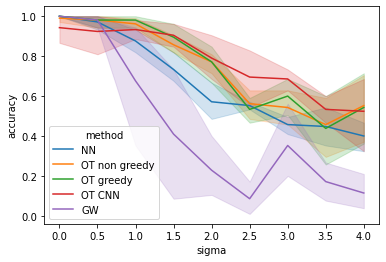

In [358]:
sns.lineplot(data=res_Ecuador, x="sigma", y="accuracy", hue="method")

In [359]:
res_Ecuador.to_csv('Ecuador/results/evaluation_nn_ot_gw.csv')

<AxesSubplot:xlabel='sigma', ylabel='accuracy'>

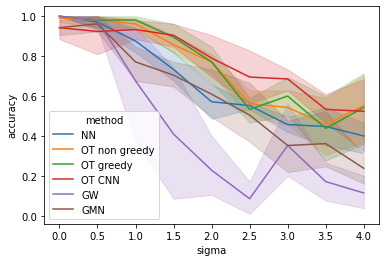

In [360]:
res_Ecuador_gmn = pd.read_csv('Ecuador/results/evaluation_gmn.csv')
res_Ecuador = pd.concat([res_Ecuador, res_Ecuador_gmn])

<AxesSubplot:title={'center':'Evaluation of Mapping Methods when Increasing Noise in GPS coordinates of Ground Measurements\n (Synthetic Dataset based on 105 trees in Ecuador)'}, xlabel='sigma (m)', ylabel='accuracy'>

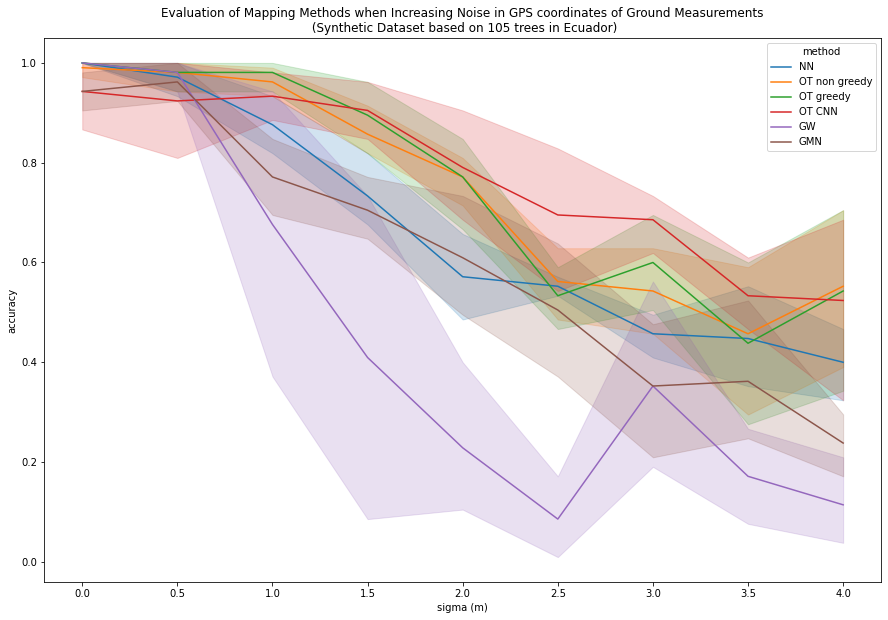

In [368]:
fig, ax = plt.subplots(figsize=[15, 10])
ax.set_xlabel('sigma (m)')
ax.set_ylabel('accuracy')
ax.set_title('Evaluation of Mapping Methods when Increasing Noise in GPS coordinates of Ground Measurements\n (Synthetic Dataset based on 105 trees in Ecuador)')

sns.lineplot(data=res_Ecuador, x="sigma", y="accuracy", hue="method", ax=ax)

## Evaluate Matching Methods on NEON

In [5]:
df = pd.read_csv('NEON/data/true_matching.csv', index_col = 0)
len(df)

3839

In [6]:
df.columns

Index(['uid', 'namedLocation', 'date', 'eventID', 'domainID', 'siteID',
       'plotID', 'subplotID', 'nestedSubplotID', 'pointID', 'stemDistance',
       'stemAzimuth', 'recordType', 'individualID',
       'supportingStemIndividualID', 'previouslyTaggedAs',
       'samplingProtocolVersion', 'taxonID', 'scientificName', 'taxonRank',
       'identificationReferences', 'morphospeciesID', 'morphospeciesIDRemarks',
       'identificationQualifier', 'remarks', 'measuredBy', 'recordedBy',
       'dataQF', 'plotType', 'subtype', 'plotLatitude', 'plotLongitude',
       'datum', 'utmZone', 'easting', 'northing', 'horzUncert', 'crdSource',
       'elevation', 'vertUncert', 'nlcdClass', 'appMods', 'geometry', 'X', 'Y',
       'itcLongitude', 'itcLatitude', 'adjNorthing', 'adjEasting',
       'adjDecimalLatitude', 'adjDecimalLongitude', 'tempShrubStemID',
       'tagStatus', 'growthForm', 'plantStatus', 'stemDiameter',
       'measurementHeight', 'height', 'baseCrownHeight', 'breakHeight',
       

In [12]:
df.scientificName.loc[0]

'Pseudotsuga menziesii (Mirb.) Franco var. menziesii'

In [19]:
# initialize empty map zoomed in on 
m = folium.Map(location=[30, 120], zoom_start=13,tiles='CartoDBPositron')


X_street = df[['plotLatitude', 'plotLongitude']].to_numpy()
#add markers

for i in range(len(X_street)):
    #folium.Marker(each, icon=folium.Icon(color='blue', icon='cloud')).add_to(m)
    #print(df.scientificName.loc[i], df.stemDiameter.loc[i], df.height.loc[i])
    #my_string = '<b>Species</b>: {}, <br><b>Diameter</b>: {},  <br><b>Height</b>: {}'.format(df.scientificName.loc[i], df.stemDiameter.loc[i], df.height.loc[i])  
    #folium.CircleMarker(location=X_street[i], radius=3, weight = 0, fill_color='blue', fill_opacity=0.4, popup = Popup(my_string)).add_to(m)
    folium.CircleMarker(location=X_street[i], radius=3, weight = 0, fill_color='red', fill_opacity=0.4).add_to(m)

folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
    ).add_to(m)

In [20]:
m

68


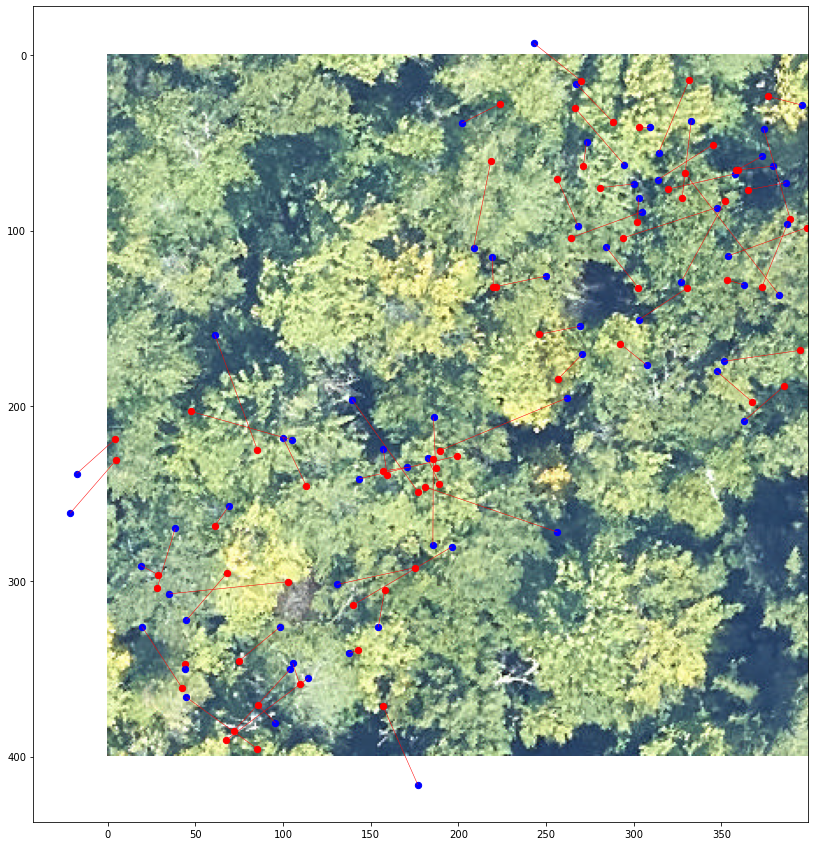

In [291]:
# Plot on one tile 'BART_036.tif'

sub = df[df.img_path == 'BART_036.tif']
X_drone = sub[['x', 'y']].to_numpy()
print(len(X_drone))
n = len(X_drone)

sigma = 30
noise = np.random.normal(0, sigma, (n, 2))
X_ground = X_drone + noise

src = rasterio.open('NEON/images/BART_036.tif')
raster = src.read()
image = reshape_as_image(raster)

plt.figure(figsize=(15,15))
plt.imshow(image.astype(int))

for i in range(len(X_drone)):
    plt.scatter(x=X_drone[i][0], y=X_drone[i][1], c='r', s=40)
    plt.scatter(x=X_ground[i][0], y=X_ground[i][1], c='b', s=40)
    plt.plot([X_ground[i][0], X_drone[i][0]], [X_ground[i][1], X_drone[i][1]], color='red', marker=None, linewidth=0.5, markersize=2)
plt.show()

In [376]:
def evaluation_noise(sigmas, X_drone):
    
    Acc_nn = []
    Acc_ot_non_greedy = []
    Acc_ot_greedy = []
    Acc_ot_cnn = []
    Acc_gw = []
    

    n = len(X_drone)
    for k in range(len(sigmas)):
        noise = np.random.normal(0, sigmas[k], (n, 2))
        X_ground = X_drone + noise
        
        y_true = range(n)

        # Nearest Neighbours
        X_drone_nn = np.hstack((X_drone, np.zeros((n, 1), dtype=np.int32)))
        X_ground_nn = np.hstack((X_ground, np.zeros((n, 1), dtype=np.int32)+1))
        idx = index_nn(X_ground_nn, X_drone_nn)
        if k == 0:
            np.save('NEON/results/index_NN_sigma_0.npy', idx)
        Acc_nn.append(accuracy_score(y_true, idx))
        #plot_mapping(X_drone, X_ground, idx)

        # OT ground to drone
        G = OT_sinkhorn(X_drone, X_ground, lambd = 0.01)
        idx = np.argmax(G, axis = 0)
        if k == 0:
            np.save('NEON/results/index_OT non greedy_sigma_0.npy', idx)
        Acc_ot_non_greedy.append(accuracy_score(y_true, idx))
        #plot_mapping(X_drone, X_ground, idx)
        
        # OT greedy
        G = OT_sinkhorn(X_drone, X_ground, lambd = 0.01)
        cost = -G*10e4
        row_ind, col_ind = linear_sum_assignment(cost)
        Acc_ot_greedy.append(accuracy_score(y_true, col_ind))
        #plot_mapping_inv(X_drone, X_ground, idx)
        
        
        # Gromov-Wasserstein
        G = gromov_wasserstein(X_drone, X_ground)
        idx = np.argmax(G, axis = 0)
        Acc_gw.append(accuracy_score(y_true, idx))
        
        
    return(Acc_nn, Acc_ot_non_greedy, Acc_ot_greedy, Acc_ot_cnn, Acc_gw)

In [377]:
sigmas = np.array([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4])

def run_evaluation_test(Test, sigmas):
    LIST_ACC_TEST = []
    res = pd.DataFrame(columns=['sigma', 'accuracy', 'method', 'test'])
    k = 0
    for df_test in Test:
        k +=1
        Acc_nn_sites = []
        Acc_ot_non_greedy_sites = []
        Acc_ot_greedy_sites = []
        Acc_gw_sites = []
        list_site = np.unique(df_test['site'].to_numpy())
        for name in list_site:
            site = df_test[df_test.site == name]
            
            X_drone = site[['X', 'Y']].to_numpy()
            if(len(site)>1):
                Acc_nn, Acc_ot_non_greedy, Acc_ot_greedy,_, Acc_gw = evaluation_noise(sigmas, X_drone)
                Acc_nn_sites.append(Acc_nn)
                Acc_ot_non_greedy_sites.append(Acc_ot_non_greedy)
                Acc_ot_greedy_sites.append(Acc_ot_greedy)
                Acc_gw_sites.append(Acc_gw)
        
        ACC_TEST = [np.mean(Acc_nn_sites, axis = 0), np.mean(Acc_ot_non_greedy_sites, axis = 0), np.mean(Acc_ot_greedy_sites, axis = 0), np.mean(Acc_gw_sites, axis = 0)]
        methods = ['NN', 'OT non greedy', 'OT greedy', 'GW']
        n = len(sigmas)
        for i in range(len(methods)):
            df_sup = pd.DataFrame()
            df_sup['sigma'] = sigmas
            df_sup['accuracy'] = ACC_TEST[i]
            df_sup['method'] = [methods[i]]*n
            df_sup['test'] = [k]*n
            res = pd.concat([res, df_sup], ignore_index=True)
            
        #print("ACC_TEST is: ", ACC_TEST)
        #LIST_ACC_TEST.append(ACC_TEST)
    return(res)
        

In [378]:
new_df = df.copy()
n = len(new_df)
N = int(n*0.2)
Test = []
for i in range(5):
    test = new_df.sample(n=N, random_state=1)
    Test.append(test)
    new_df = new_df.drop(test.index) 

In [379]:
res = run_evaluation_test(Test, sigmas)
res

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=46 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=46 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=46 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=46 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

23 23
23 23
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.809342e-01|0.000000e+00|0.000000e+00
    1|5.792468e-17|6.576372e+15|3.809342e-01
    2|5.792468e-17|0.000000e+00|0.000000e+00
23 23
23 23
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.814532e-01|0.000000e+00|0.000000e+00
    1|3.568539e-04|1.067934e+03|3.810964e-01
    2|3.990665e-06|8.842216e+01|3.528632e-04
    3|3.990665e-06|0.000000e+00|0.000000e+00
23 23
23 23
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.775231e-01|0.000000e+00|0.000000e+00
    1|1.155869e-01|2.266140e+00|2.619362e-01
    2|3.881988e-05|2.976519e+03|1.155481e-01
    3|3.881988e-05|0.000000e+00|0.000000e+00
23 23
23 23
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.805874e-01|0.000000e+00|0.000000e+00
    1|2.907295e-05|1.308977e

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=8 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=8 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=8 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


 4
4 4
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.223638e-01|0.000000e+00|0.000000e+00
    1|6.141559e-02|2.620640e+00|1.609482e-01
    2|6.141559e-02|0.000000e+00|0.000000e+00
4 4
4 4
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.421802e-01|0.000000e+00|0.000000e+00
    1|8.295930e-03|2.819265e+01|2.338842e-01
    2|8.295930e-03|0.000000e+00|0.000000e+00
4 4
4 4
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.303186e-01|0.000000e+00|0.000000e+00
    1|3.436343e-03|6.602435e+01|2.268823e-01
    2|3.436343e-03|0.000000e+00|0.000000e+00
4 4
4 4
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.156597e-01|0.000000e+00|0.000000e+00
    1|2.228021e-03|9.579429e+01|2.134316e-01
    2|2.228021e-03|0.000000e+00|0.000000e+00
4 4
4 4
It.  |Loss        |Relative loss|Abso

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=8 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=8 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=8 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=8 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.174623e-01|0.000000e+00|0.000000e+00
    1|3.267922e-02|5.654453e+00|1.847831e-01
    2|3.267922e-02|0.000000e+00|0.000000e+00
4 4
4 4
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.608233e-01|0.000000e+00|0.000000e+00
    1|7.101173e-02|2.672961e+00|1.898116e-01
    2|7.101173e-02|0.000000e+00|0.000000e+00
22 22
22 22
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.348747e-01|0.000000e+00|0.000000e+00
    1|-3.027881e-17|7.757065e+15|2.348747e-01
    2|-3.027881e-17|0.000000e+00|0.000000e+00
22 22
22 22
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.349134e-01|0.000000e+00|0.000000e+00
    1|2.340361e-07|1.003748e+06|2.349132e-01
    2|1.783085e-08|1.212535e+01|2.162052e-07


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=44 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=44 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=44 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


    3|1.783085e-08|0.000000e+00|0.000000e+00
22 22
22 22
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.348754e-01|0.000000e+00|0.000000e+00
    1|5.927208e-07|3.962654e+05|2.348748e-01
    2|4.716801e-08|1.156616e+01|5.455528e-07
    3|4.716801e-08|0.000000e+00|0.000000e+00
22 22
22 22
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.348557e-01|0.000000e+00|0.000000e+00
    1|7.900001e-07|2.972847e+05|2.348549e-01
    2|1.299237e-07|5.080493e+00|6.600764e-07
    3|1.299237e-07|0.000000e+00|0.000000e+00
22 22


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=44 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=44 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=44 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


22 22
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.346825e-01|0.000000e+00|0.000000e+00
    1|9.185529e-07|2.554906e+05|2.346816e-01
    2|2.819197e-07|2.258207e+00|6.366332e-07
    3|2.819197e-07|0.000000e+00|0.000000e+00
22 22
22 22
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.345228e-01|0.000000e+00|0.000000e+00
    1|1.458493e-06|1.607970e+05|2.345213e-01
    2|8.161254e-07|7.870939e-01|6.423673e-07
    3|8.161254e-07|0.000000e+00|0.000000e+00
22 22
22 22
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.347340e-01|0.000000e+00|0.000000e+00
    1|8.355934e-07|2.809179e+05|2.347331e-01
    2|5.290627e-07|5.793846e-01|3.065308e-07
    3|5.007279e-07|5.658716e-02|2.833477e-08
    4|5.007279e-07|0.000000e+00|0.000000e+00
22 22


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=44 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=44 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=44 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


22 22
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.345689e-01|0.000000e+00|0.000000e+00
    1|1.417201e-06|1.655146e+05|2.345675e-01
    2|1.070774e-06|3.235297e-01|3.464272e-07
    3|1.070774e-06|0.000000e+00|0.000000e+00
22 22
22 22
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.344377e-01|0.000000e+00|0.000000e+00
    1|1.729051e-02|1.255875e+01|2.171472e-01
    2|1.564922e-06|1.104780e+04|1.728895e-02
    3|1.502630e-06|4.145550e-02|6.229226e-08
    4|1.502630e-06|0.000000e+00|0.000000e+00
9 9
9 9
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.889904e-01|0.000000e+00|0.000000e+00
    1|-1.233581e-17|3.963991e+16|4.889904e-01
    2|-1.233581e-17|0.000000e+00|0.000000e+00
9 9
9 9
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.890405e-01|0.000000e+00|0.000000

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=18 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=18 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=18 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=18 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

    1|2.039208e-06|2.354808e+05|4.801943e-01
    2|2.039208e-06|0.000000e+00|0.000000e+00
9 9
9 9
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.797236e-01|0.000000e+00|0.000000e+00
    1|2.941782e-05|1.630625e+04|4.796942e-01
    2|4.429797e-06|5.640896e+00|2.498802e-05
    3|4.429797e-06|0.000000e+00|0.000000e+00
9 9
9 9
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.807325e-01|0.000000e+00|0.000000e+00
    1|1.078589e-06|4.457039e+05|4.807314e-01
    2|1.078589e-06|0.000000e+00|0.000000e+00
9 9
9 9
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.797916e-01|0.000000e+00|0.000000e+00
    1|6.706479e-06|7.154052e+04|4.797849e-01
    2|5.445880e-06|2.314774e-01|1.260598e-06
    3|5.445880e-06|0.000000e+00|0.000000e+00
9 9
9 9
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=58 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=58 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=58 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


29 29
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.635034e-01|0.000000e+00|0.000000e+00
    1|6.556489e-07|4.018961e+05|2.635028e-01
    2|3.684770e-08|1.679348e+01|6.188012e-07
    3|3.684770e-08|0.000000e+00|0.000000e+00
29 29
29 29
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.634012e-01|0.000000e+00|0.000000e+00
    1|7.784639e-07|3.383592e+05|2.634004e-01
    2|6.587670e-08|1.081698e+01|7.125872e-07
    3|6.587670e-08|0.000000e+00|0.000000e+00
29 29
29 29
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.634949e-01|0.000000e+00|0.000000e+00
    1|6.256952e-07|4.211224e+05|2.634943e-01
    2|1.782039e-07|2.511120e+00|4.474913e-07
    3|1.552294e-07|1.480031e-01|2.297444e-08
    4|1.552294e-07|0.000000e+00|0.000000e+00
29 29
29 29
It.  |Loss        |Relative loss|Absolute loss
--------------------------------------

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=58 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=58 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=58 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.632989e-01|0.000000e+00|0.000000e+00
    1|1.090994e-06|2.413376e+05|2.632978e-01
    2|3.928216e-07|1.777326e+00|6.981720e-07
    3|3.643340e-07|7.819099e-02|2.848764e-08
    4|3.643340e-07|0.000000e+00|0.000000e+00
29 29
29 29
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.630198e-01|0.000000e+00|0.000000e+00
    1|1.224295e-06|2.148327e+05|2.630185e-01
    2|9.384785e-07|3.045526e-01|2.858160e-07
    3|8.481314e-07|1.065249e-01|9.034710e-08
    4|8.481314e-07|0.000000e+00|0.000000e+00
44 44
44 44
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.119081e-01|0.000000e+00|0.000000e+00
    1|7.569702e-18|4.120480e+16|3.119081e-01
    2|7.569702e-18|0.000000e+00|0.000000e+00
44 44
44 44
It.  |Loss        |Relative loss|Absolute loss
--------------------------------------------

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=58 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=88 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=88 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=88 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


44 44
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.108839e-01|0.000000e+00|0.000000e+00
    1|1.220902e-05|2.546246e+04|3.108717e-01
    2|8.883406e-06|3.743627e-01|3.325616e-06
    3|8.883406e-06|0.000000e+00|0.000000e+00
44 44
44 44
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.099027e-01|0.000000e+00|0.000000e+00
    1|2.776602e-04|1.115122e+03|3.096251e-01
    2|2.555976e-05|9.863177e+00|2.521004e-04
    3|2.547808e-05|3.205807e-03|8.167782e-08
    4|2.547808e-05|0.000000e+00|0.000000e+00
44 44
44 44
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.086041e-01|0.000000e+00|0.000000e+00
    1|2.837600e-04|1.086553e+03|3.083204e-01
    2|5.801469e-05|3.891175e+00|2.257453e-04
    3|5.801469e-05|0.000000e+00|0.000000e+00
44 44
44 44

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=88 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=88 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=88 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.112128e-01|0.000000e+00|0.000000e+00
    1|3.744112e-04|8.302059e+02|3.108384e-01
    2|2.790371e-05|1.241797e+01|3.465075e-04
    3|2.790371e-05|0.000000e+00|0.000000e+00
44 44
44 44
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.109310e-01|0.000000e+00|0.000000e+00
    1|4.364115e-04|7.114721e+02|3.104946e-01
    2|3.736677e-05|1.067913e+01|3.990447e-04
    3|3.736677e-05|0.000000e+00|0.000000e+00
44 44
44 44
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.130056e-01|0.000000e+00|0.000000e+00
    1|5.546743e-04|5.633051e+02|3.124509e-01
    2|5.573797e-05|8.951462e+00|4.989363e-04
    3|5.573797e-05|0.000000e+00|0.000000e+00
44 44
44 44


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=88 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=88 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=88 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=18 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.121988e-01|0.000000e+00|0.000000e+00
    1|2.483601e-04|1.256041e+03|3.119505e-01
    2|8.272766e-05|2.002140e+00|1.656324e-04
    3|7.940693e-05|4.181923e-02|3.320737e-06
    4|7.940693e-05|0.000000e+00|0.000000e+00
9 9
9 9
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.194132e-01|0.000000e+00|0.000000e+00
    1|-9.868649e-17|3.236646e+15|3.194132e-01
    2|-9.868649e-17|0.000000e+00|0.000000e+00
9 9
9 9
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.193164e-01|0.000000e+00|0.000000e+00
    1|1.991166e-06|1.603655e+05|3.193144e-01
    2|1.991166e-06|0.000000e+00|0.000000e+00
9 9
9 9


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=18 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=18 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=18 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.201945e-01|0.000000e+00|0.000000e+00
    1|7.071414e-06|4.527912e+04|3.201874e-01
    2|7.071414e-06|0.000000e+00|0.000000e+00
9 9
9 9
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.192435e-01|0.000000e+00|0.000000e+00
    1|4.629606e-05|6.894695e+03|3.191972e-01
    2|4.629606e-05|0.000000e+00|0.000000e+00
9 9
9 9
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.200233e-01|0.000000e+00|0.000000e+00
    1|1.706955e-05|1.874720e+04|3.200062e-01
    2|1.706955e-05|0.000000e+00|0.000000e+00
9 9


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=18 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=18 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=18 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


9 9
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.199611e-01|0.000000e+00|0.000000e+00
    1|1.280891e-05|2.497859e+04|3.199483e-01
    2|1.280891e-05|0.000000e+00|0.000000e+00
9 9
9 9
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.163424e-01|0.000000e+00|0.000000e+00
    1|8.137127e-05|3.886642e+03|3.162610e-01
    2|8.137127e-05|0.000000e+00|0.000000e+00
9 9
9 9


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=18 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=18 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=22 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=22 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.181333e-01|0.000000e+00|0.000000e+00
    1|1.374004e-04|2.314374e+03|3.179959e-01
    2|1.374004e-04|0.000000e+00|0.000000e+00
9 9
9 9
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.133755e-01|0.000000e+00|0.000000e+00
    1|2.290135e-04|1.367371e+03|3.131465e-01
    2|2.290135e-04|0.000000e+00|0.000000e+00
11 11
11 11
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.745361e-01|0.000000e+00|0.000000e+00
    1|2.018587e-17|2.350833e+16|4.745361e-01
    2|2.018587e-17|0.000000e+00|0.000000e+00
11 11
11 11
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.744446e-01|0.000000e+00|0.000000e+00
    1|1.178868e-06|4.024568e+05|4.744434e-01
    2|1.178868e-06|0.000000e+00|0.000000e+00
11 11
11 11
It.  |Loss        |Relative loss

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=22 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=22 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=22 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=166 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70

83 83
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.668759e-01|0.000000e+00|0.000000e+00
    1|2.207070e-17|7.560971e+15|1.668759e-01
    2|2.207070e-17|0.000000e+00|0.000000e+00
83 83
83 83
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.668597e-01|0.000000e+00|0.000000e+00
    1|1.996508e-03|8.257579e+01|1.648632e-01
    2|9.531942e-07|2.093544e+03|1.995554e-03
    3|9.531942e-07|0.000000e+00|0.000000e+00
83 83


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=166 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=166 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=166 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


83 83
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.667457e-01|0.000000e+00|0.000000e+00
    1|2.590339e-03|6.337217e+01|1.641554e-01
    2|3.067317e-06|8.434966e+02|2.587271e-03
    3|3.067317e-06|0.000000e+00|0.000000e+00
83 83
83 83
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.666752e-01|0.000000e+00|0.000000e+00
    1|3.501655e-03|4.659897e+01|1.631735e-01
    2|8.453790e-06|4.132113e+02|3.493201e-03
    3|8.453790e-06|0.000000e+00|0.000000e+00
83 83
83 83
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.655351e-01|0.000000e+00|0.000000e+00
    1|3.714845e-03|4.356043e+01|1.618202e-01
    2|3.167649e-05|1.162745e+02|3.683168e-03
    3|3.154004e-05|4.326254e-03|1.364502e-07
    4|3.154004e-05|0.000000e+00|0.000000e+00


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=166 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=166 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=166 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


83 83
83 83
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.668386e-01|0.000000e+00|0.000000e+00
    1|2.727018e-03|6.017986e+01|1.641116e-01
    2|1.662891e-05|1.629926e+02|2.710389e-03
    3|1.647654e-05|9.247633e-03|1.523690e-07
    4|1.647654e-05|0.000000e+00|0.000000e+00
83 83
83 83
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.655270e-01|0.000000e+00|0.000000e+00
    1|5.282435e-03|3.033536e+01|1.602446e-01
    2|4.441573e-05|1.179316e+02|5.238019e-03
    3|4.271556e-05|3.980205e-02|1.700167e-06
    4|4.271556e-05|0.000000e+00|0.000000e+00
83 83
83 83
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.637890e-01|0.000000e+00|0.000000e+00
    1|4.422113e-03|3.603864e+01|1.593669e-01
    2|1.357848e-04|3.156707e+01|4.286328e-03
    3|1.293142e-04|5.003753e-02|6.470564e-06
    4|1.293142e-04|0.000000e+00|0.000000e+00
8

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=166 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=210 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=210 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


105 105
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.477145e-02|0.000000e+00|0.000000e+00
    1|8.077805e-03|1.073233e+01|8.669365e-02
    2|4.591862e-08|1.759147e+05|8.077759e-03
    3|4.591862e-08|0.000000e+00|0.000000e+00
105 105
105 105
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.476766e-02|0.000000e+00|0.000000e+00
    1|1.201917e-02|6.884712e+00|8.274850e-02
    2|1.715819e-07|7.004814e+04|1.201899e-02
    3|1.715819e-07|0.000000e+00|0.000000e+00
105 105


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=210 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=210 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


105 105
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.480753e-02|0.000000e+00|0.000000e+00
    1|1.364481e-02|5.948247e+00|8.116272e-02
    2|3.119047e-07|4.374573e+04|1.364450e-02
    3|3.107848e-07|3.603586e-03|1.119940e-09
    4|3.107848e-07|0.000000e+00|0.000000e+00
105 105
105 105


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=210 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=210 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.473652e-02|0.000000e+00|0.000000e+00
    1|1.863394e-02|4.084083e+00|7.610258e-02
    2|5.833634e-07|3.194126e+04|1.863336e-02
    3|5.798935e-07|5.983634e-03|3.469870e-09
    4|5.798935e-07|0.000000e+00|0.000000e+00
105 105
105 105
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.478356e-02|0.000000e+00|0.000000e+00
    1|1.207896e-02|6.846998e+00|8.270460e-02
    2|9.049179e-07|1.334713e+04|1.207805e-02
    3|8.968787e-07|8.963520e-03|8.039190e-09
    4|8.968787e-07|0.000000e+00|0.000000e+00
105 105


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=210 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


105 105
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.451041e-02|0.000000e+00|0.000000e+00
    1|1.740940e-02|4.428700e+00|7.710101e-02
    2|2.410312e-06|7.221882e+03|1.740699e-02
    3|2.408420e-06|7.857392e-04|1.892390e-09
    4|2.408420e-06|0.000000e+00|0.000000e+00
105 105


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=210 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=210 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


105 105
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.488503e-02|0.000000e+00|0.000000e+00
    1|1.687878e-02|4.621557e+00|7.800625e-02
    2|1.843302e-06|9.155820e+03|1.687694e-02
    3|1.842564e-06|4.004328e-04|7.378231e-10
105 105
105 105
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.455138e-02|0.000000e+00|0.000000e+00
    1|2.491604e-02|2.794799e+00|6.963534e-02
    2|2.757234e-06|9.035609e+03|2.491329e-02
    3|2.743608e-06|4.966324e-03|1.362565e-08
    4|2.743608e-06|0.000000e+00|0.000000e+00
2 2
2 2
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.000000e-01|0.000000e+00|0.000000e+00
    1|0.000000e+00|     inf|5.000000e-01
    2|0.000000e+00|     nan|0.000000e+00
2 2
2 2
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.000000e-01|0.000000e+00|0.000000e+00

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=4 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/ot/optim.py:257: RuntimeWarning: divide by zero encountered in double_scalars
  relative_delta_fval = abs_delta_fval / abs(f_val)
/anaconda3/envs/venv/lib/python3.6/site-packages/ot/optim.py:257: RuntimeWarning: invalid value encountered in double_scalars
  relative_delta_fval = abs_delta_fval / abs(f_val)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=4 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/ot/optim.py:257: RuntimeWarning: divide by zero encountered in double_scalars
  relative_delta_fval = abs_delta_fval / abs(f_val)
/anaco

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.000000e-01|0.000000e+00|0.000000e+00
    1|0.000000e+00|     inf|5.000000e-01
    2|0.000000e+00|     nan|0.000000e+00
2 2
2 2
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.000000e-01|0.000000e+00|0.000000e+00
    1|0.000000e+00|     inf|5.000000e-01
    2|0.000000e+00|     nan|0.000000e+00
2 2
2 2
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.000000e-01|0.000000e+00|0.000000e+00
    1|0.000000e+00|     inf|5.000000e-01
    2|0.000000e+00|     nan|0.000000e+00
2 2
2 2
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.000000e-01|0.000000e+00|0.000000e+00
    1|0.000000e+00|     inf|5.000000e-01
    2|0.000000e+00|     nan|0.000000e+00
60 60
60 60
It.  |Loss        |Relative loss|Absolute loss
-------------------------

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=120 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=120 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=120 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=120 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py

60 60
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.546854e-01|0.000000e+00|0.000000e+00
    1|4.034681e-04|3.823894e+02|1.542819e-01
    2|4.782864e-08|8.434701e+03|4.034202e-04
    3|4.782864e-08|0.000000e+00|0.000000e+00
60 60
60 60
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.546237e-01|0.000000e+00|0.000000e+00
    1|3.945312e-04|3.909176e+02|1.542292e-01
    2|9.917613e-08|3.977086e+03|3.944320e-04
    3|9.917613e-08|0.000000e+00|0.000000e+00
60 60
60 60
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.546098e-01|0.000000e+00|0.000000e+00
    1|6.780576e-04|2.270187e+02|1.539318e-01
    2|2.412589e-07|2.809497e+03|6.778163e-04
    3|2.412589e-07|0.000000e+00|0.000000e+00
60 60
60 60
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.546832e-01|0.000000e+00|0.

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=120 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=120 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=120 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=30 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.546241e-01|0.000000e+00|0.000000e+00
    1|6.323266e-04|2.435320e+02|1.539917e-01
    2|3.781550e-07|1.671136e+03|6.319485e-04
    3|3.781550e-07|0.000000e+00|0.000000e+00
60 60
60 60
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.544966e-01|0.000000e+00|0.000000e+00
    1|6.703539e-04|2.294703e+02|1.538263e-01
    2|6.447819e-07|1.038660e+03|6.697091e-04
    3|5.624106e-07|1.464611e-01|8.237130e-08
    4|5.624106e-07|0.000000e+00|0.000000e+00
60 60
60 60
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.546121e-01|0.000000e+00|0.000000e+00
    1|7.369240e-04|2.088074e+02|1.538751e-01
    2|1.015354e-06|7.247802e+02|7.359086e-04
    3|1.013595e-06|1.735208e-03|1.758799e-09
    4|1.013595e-06|0.000000e+00|0.000000e+00
15 15
15 15
It.  |Loss        |Relative loss|Absolute loss

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=30 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=30 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=30 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=30 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

    3|5.532929e-07|9.310338e+00|5.151344e-06
    4|5.532929e-07|0.000000e+00|0.000000e+00
13 13
13 13
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.302178e-01|0.000000e+00|0.000000e+00
    1|5.976974e-05|3.850745e+03|2.301580e-01
    2|1.608879e-06|3.614993e+01|5.816086e-05
    3|1.608879e-06|0.000000e+00|0.000000e+00
13 13
13 13
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.311695e-01|0.000000e+00|0.000000e+00
    1|1.132898e-04|2.039516e+03|2.310562e-01
    2|1.132898e-04|0.000000e+00|0.000000e+00
13 13
13 13
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.297602e-01|0.000000e+00|0.000000e+00
    1|1.163860e-04|1.973123e+03|2.296438e-01
    2|1.040393e-05|1.018673e+01|1.059820e-04
    3|5.378324e-06|9.344183e-01|5.025605e-06
    4|5.378324e-06|0.000000e+00|0.000000e+00
13 13
13 13
It.  |Loss        |Relative loss|A

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=76 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=76 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=76 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.303064e-02|0.000000e+00|0.000000e+00
    1|1.462953e-06|3.624804e+04|5.302917e-02
    2|2.652070e-07|4.516267e+00|1.197746e-06
    3|2.652070e-07|0.000000e+00|0.000000e+00
38 38
38 38
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.304010e-02|0.000000e+00|0.000000e+00
    1|6.565273e-07|8.078788e+04|5.303945e-02
    2|4.071693e-07|6.124186e-01|2.493580e-07
    3|4.071693e-07|0.000000e+00|0.000000e+00
38 38
38 38
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.308804e-02|0.000000e+00|0.000000e+00
    1|2.196152e-06|2.417221e+04|5.308585e-02
    2|6.518816e-07|2.368943e+00|1.544270e-06
    3|6.518816e-07|0.000000e+00|0.000000e+00
38 38
38 38


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=76 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=76 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=76 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.303274e-02|0.000000e+00|0.000000e+00
    1|8.404453e-07|6.309976e+04|5.303190e-02
    2|7.404302e-07|1.350770e-01|1.000151e-07
    3|7.404302e-07|0.000000e+00|0.000000e+00
38 38
38 38
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.303399e-02|0.000000e+00|0.000000e+00
    1|2.474246e-06|2.143341e+04|5.303152e-02
    2|1.000698e-06|1.472519e+00|1.473548e-06
    3|1.000698e-06|0.000000e+00|0.000000e+00
18 18
18 18
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.512544e-01|0.000000e+00|0.000000e+00
    1|1.233581e-17|2.847436e+16|3.512544e-01
    2|1.233581e-17|0.000000e+00|0.000000e+00
18 18
18 18
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.518099e-01|0.000000e+00|0.000000e+00
    1|7.149828e-04|4.910537e+02|3.510950

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=76 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=36 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=36 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=36 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

165 165
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.068574e-01|0.000000e+00|0.000000e+00
    1|1.480297e-17|7.218643e+15|1.068574e-01
    2|1.480297e-17|0.000000e+00|0.000000e+00
165 165


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=330 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


165 165
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.067814e-01|0.000000e+00|0.000000e+00
    1|1.308549e-02|7.160294e+00|9.369596e-02
    2|3.587175e-07|3.647754e+04|1.308513e-02
    3|3.587175e-07|0.000000e+00|0.000000e+00
165 165
165 165


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=330 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=330 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.067745e-01|0.000000e+00|0.000000e+00
    1|1.805748e-02|4.913034e+00|8.871700e-02
    2|1.183380e-06|1.525824e+04|1.805629e-02
    3|1.183380e-06|0.000000e+00|0.000000e+00
165 165
165 165
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.067716e-01|0.000000e+00|0.000000e+00
    1|2.346658e-02|3.549942e+00|8.330498e-02
    2|2.156621e-06|1.088018e+04|2.346442e-02
    3|2.156431e-06|8.784619e-05|1.894343e-10
165 165
165 165
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.065489e-01|0.000000e+00|0.000000e+00
    1|2.369342e-02|3.496983e+00|8.285549e-02
    2|5.159116e-06|4.591535e+03|2.368826e-02
    3|5.150968e-06|1.581909e-03|8.148361e-09
    4|5.150968e-06|0.000000e+00|0.000000e+00
165 165


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=330 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=330 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


165 165
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.067982e-01|0.000000e+00|0.000000e+00
    1|1.873471e-02|4.700556e+00|8.806352e-02
    2|5.985602e-06|3.128962e+03|1.872872e-02
    3|5.959758e-06|4.336425e-03|2.584404e-08
    4|5.959758e-06|0.000000e+00|0.000000e+00
165 165


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=330 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


165 165
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.066051e-01|0.000000e+00|0.000000e+00
    1|3.139574e-02|2.395528e+00|7.520936e-02
    2|8.125227e-06|3.862983e+03|3.138761e-02
    3|8.008461e-06|1.458040e-02|1.167665e-07
    4|8.008461e-06|0.000000e+00|0.000000e+00
165 165
165 165


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=330 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=330 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.065852e-01|0.000000e+00|0.000000e+00
    1|2.648152e-02|3.024889e+00|8.010368e-02
    2|1.047673e-05|2.526651e+03|2.647105e-02
    3|1.047673e-05|0.000000e+00|0.000000e+00
165 165
165 165
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.060202e-01|0.000000e+00|0.000000e+00
    1|2.513591e-02|3.217876e+00|8.088424e-02
    2|2.614700e-05|9.603307e+02|2.510977e-02
    3|2.604092e-05|4.073396e-03|1.060750e-07
    4|2.604092e-05|0.000000e+00|0.000000e+00
24 24
24 24
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.974467e-01|0.000000e+00|0.000000e+00
    1|1.387779e-17|1.422753e+16|1.974467e-01
    2|1.387779e-17|0.000000e+00|0.000000e+00
24 24
24 24
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.974820e-01|0.000000e+00|0.00

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=48 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=48 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=48 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=48 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.974702e-01|0.000000e+00|0.000000e+00
    1|7.604482e-06|2.596661e+04|1.974626e-01
    2|8.270493e-07|8.194715e+00|6.777433e-06
    3|8.270493e-07|0.000000e+00|0.000000e+00
38 38
38 38
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.062639e-01|0.000000e+00|0.000000e+00
    1|-2.045148e-17|1.008553e+16|2.062639e-01
    2|-2.045148e-17|0.000000e+00|0.000000e+00
38 38
38 38
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.061509e-01|0.000000e+00|0.000000e+00
    1|1.851564e-02|1.013388e+01|1.876353e-01
    2|7.040191e-07|2.629891e+04|1.851494e-02
    3|7.040191e-07|0.000000e+00|0.000000e+00
38 38
38 38
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.064348e-01|0.000000e+00|0.000000e+00
    1|1.866914e-02|1.005755e+01|1.8776

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=76 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=76 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=76 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


38 38
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.056845e-01|0.000000e+00|0.000000e+00
    1|3.086504e-02|5.663996e+00|1.748194e-01
    2|7.591093e-06|4.064955e+03|3.085745e-02
    3|7.591093e-06|0.000000e+00|0.000000e+00
38 38
38 38
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.064299e-01|0.000000e+00|0.000000e+00
    1|4.533009e-02|3.553927e+00|1.610998e-01
    2|1.368055e-05|3.312470e+03|4.531641e-02
    3|1.333383e-05|2.600295e-02|3.467189e-07
    4|1.333383e-05|0.000000e+00|0.000000e+00
38 38
38 38
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.064463e-01|0.000000e+00|0.000000e+00
    1|6.232151e-02|2.312601e+00|1.441248e-01
    2|1.878884e-05|3.315943e+03|6.230272e-02
    3|1.878884e-05|0.000000e+00|0.000000e+00
38 38
38 38
It.  |Loss        |Relative loss|Absolute loss
--------------------------------------

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=76 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=76 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=76 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


38 38
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.066479e-01|0.000000e+00|0.000000e+00
    1|6.230802e-02|2.316553e+00|1.443398e-01
    2|3.683672e-05|1.690465e+03|6.227118e-02
    3|3.542599e-05|3.982178e-02|1.410726e-06
    4|3.542599e-05|0.000000e+00|0.000000e+00
17 17
17 17
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.865383e-01|0.000000e+00|0.000000e+00
    1|1.306145e-17|2.959383e+16|3.865383e-01
    2|1.306145e-17|0.000000e+00|0.000000e+00
17 17
17 17
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.862939e-01|0.000000e+00|0.000000e+00
    1|3.125748e-06|1.235835e+05|3.862908e-01
    2|3.125748e-06|0.000000e+00|0.000000e+00
17 17
17 17
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.868837e-01|0.000000e+00|0.000000e+00
    1|2.919381e-04|1.324225e+03|3.

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=34 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=34 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=34 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=34 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

31 31
31 31
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.748086e-01|0.000000e+00|0.000000e+00
    1|3.716162e-04|7.384958e+02|2.744370e-01
    2|1.645268e-04|1.258696e+00|2.070893e-04
    3|1.645268e-04|0.000000e+00|0.000000e+00
31 31
31 31
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.803681e-01|0.000000e+00|0.000000e+00
    1|5.127071e-04|5.458389e+02|2.798554e-01
    2|1.818937e-04|1.818719e+00|3.308134e-04
    3|1.818937e-04|0.000000e+00|0.000000e+00
31 31
31 31
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.724094e-01|0.000000e+00|0.000000e+00
    1|5.750127e-02|3.737450e+00|2.149081e-01
    2|3.732965e-04|1.530365e+02|5.712798e-02
    3|3.732965e-04|0.000000e+00|0.000000e+00
31 31
31 31
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.670609e-01|0.000000e

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=14 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=14 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=14 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=14 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

26 26
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.214229e-01|0.000000e+00|0.000000e+00
    1|2.023727e-08|1.094134e+07|2.214229e-01
    2|1.042376e-08|9.414561e-01|9.813509e-09
    3|1.042376e-08|0.000000e+00|0.000000e+00
26 26
26 26
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.213797e-01|0.000000e+00|0.000000e+00
    1|4.250992e-07|5.207708e+05|2.213793e-01
    2|7.402631e-08|4.742542e+00|3.510729e-07
    3|7.402631e-08|0.000000e+00|0.000000e+00
26 26


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=52 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=52 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=52 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


26 26
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.213648e-01|0.000000e+00|0.000000e+00
    1|5.573651e-07|3.971620e+05|2.213642e-01
    2|1.438372e-07|2.874971e+00|4.135278e-07
    3|1.396648e-07|2.987452e-02|4.172419e-09
    4|1.396648e-07|0.000000e+00|0.000000e+00
26 26
26 26
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.214350e-01|0.000000e+00|0.000000e+00
    1|5.541283e-07|3.996086e+05|2.214344e-01
    2|1.863625e-07|1.973389e+00|3.677657e-07
    3|1.863625e-07|0.000000e+00|0.000000e+00
26 26
26 26
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.215318e-01|0.000000e+00|0.000000e+00
    1|5.578609e-07|3.971084e+05|2.215312e-01
    2|4.059234e-07|3.743009e-01|1.519375e-07
    3|4.059234e-07|0.000000e+00|0.000000e+00
26 26


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=52 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=52 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=52 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=18 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

26 26
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.212182e-01|0.000000e+00|0.000000e+00
    1|7.542362e-07|2.932999e+05|2.212174e-01
    2|5.507269e-07|3.695285e-01|2.035093e-07
    3|5.507269e-07|0.000000e+00|0.000000e+00
26 26
26 26
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.213469e-01|0.000000e+00|0.000000e+00
    1|6.620093e-07|3.343551e+05|2.213462e-01
    2|4.937464e-07|3.407881e-01|1.682629e-07
    3|4.937464e-07|0.000000e+00|0.000000e+00
26 26
26 26
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.210468e-01|0.000000e+00|0.000000e+00
    1|1.239011e-06|1.784049e+05|2.210456e-01
    2|1.035111e-06|1.969828e-01|2.038992e-07
    3|1.035111e-06|0.000000e+00|0.000000e+00
9 9
9 9
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.477731e-01|0.000000e+00|0.0000

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=18 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=18 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=18 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=18 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:


    2|6.178072e-06|0.000000e+00|0.000000e+00
9 9
9 9
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.726324e-01|0.000000e+00|0.000000e+00
    1|0.000000e+00|     inf|4.726324e-01
    2|0.000000e+00|     nan|0.000000e+00
9 9
9 9
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.727585e-01|0.000000e+00|0.000000e+00
    1|1.155338e-07|4.091949e+06|4.727583e-01
    2|1.155338e-07|0.000000e+00|0.000000e+00
9 9
9 9
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.721315e-01|0.000000e+00|0.000000e+00
    1|1.633367e-06|2.890531e+05|4.721299e-01
    2|7.752506e-07|1.106889e+00|8.581167e-07
    3|7.752506e-07|0.000000e+00|0.000000e+00
9 9
9 9
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.721185e-01|0.000000e+00|0.000000e+00
    1|2.191579e-05|2.154139e+04|4.720965e-01
    2|

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.545719e-01|0.000000e+00|0.000000e+00
    1|1.540847e-06|1.652145e+05|2.545704e-01
    2|2.152988e-07|6.156787e+00|1.325549e-06
    3|2.121949e-07|1.462719e-02|3.103815e-09
    4|2.121949e-07|0.000000e+00|0.000000e+00
21 21
21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.545827e-01|0.000000e+00|0.000000e+00
    1|1.543172e-06|1.649726e+05|2.545811e-01
    2|2.932979e-07|4.261449e+00|1.249874e-06
    3|2.788904e-07|5.165989e-02|1.440745e-08
    4|2.788904e-07|0.000000e+00|0.000000e+00
21 21
21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.545685e-01|0.000000e+00|0.000000e+00
    1|1.387187e-06|1.835132e+05|2.545671e-01
    2|9.197412e-07|5.082361e-01|4.674457e-07
    3|9.197412e-07|0.000000e+00|0.000000e+00
21 21
21 21
It.  |Loss        |Relative loss|Absolute loss

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=42 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


21 21
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.542749e-01|0.000000e+00|0.000000e+00
    1|1.887722e-06|1.346983e+05|2.542730e-01
    2|1.580518e-06|1.943696e-01|3.072045e-07
    3|1.405663e-06|1.243932e-01|1.748548e-07
    4|1.372770e-06|2.396047e-02|3.289222e-08
    5|1.372770e-06|0.000000e+00|0.000000e+00
45 45
45 45
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.446629e-01|0.000000e+00|0.000000e+00
    1|3.083953e-17|7.933418e+15|2.446629e-01
    2|3.083953e-17|0.000000e+00|0.000000e+00
45 45
45 45
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.445846e-01|0.000000e+00|0.000000e+00
    1|1.328353e-04|1.840262e+03|2.444518e-01
    2|1.349993e-06|9.739700e+01|1.314853e-04
    3|1.349993e-06|0.000000e+00|0.000000e+00
45 45


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=90 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=90 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=90 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


45 45
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.446724e-01|0.000000e+00|0.000000e+00
    1|1.182257e-04|2.068536e+03|2.445542e-01
    2|3.863235e-06|2.960278e+01|1.143625e-04
    3|3.863235e-06|0.000000e+00|0.000000e+00
45 45
45 45
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.447698e-01|0.000000e+00|0.000000e+00
    1|1.944091e-04|1.258045e+03|2.445754e-01
    2|1.385501e-05|1.303168e+01|1.805541e-04
    3|1.385501e-05|0.000000e+00|0.000000e+00
45 45
45 45
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.442392e-01|0.000000e+00|0.000000e+00
    1|1.754458e-04|1.391106e+03|2.440638e-01
    2|1.688466e-05|9.390843e+00|1.585612e-04
    3|1.602980e-05|5.332912e-02|8.548554e-07
    4|1.602980e-05|0.000000e+00|0.000000e+00
45 45
45 45


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=90 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=90 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=90 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=90 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.413899e-01|0.000000e+00|0.000000e+00
    1|3.099099e-04|7.779035e+02|2.410800e-01
    2|8.493561e-05|2.648763e+00|2.249743e-04
    3|7.523980e-05|1.288655e-01|9.695815e-06
    4|7.523980e-05|0.000000e+00|0.000000e+00
45 45
45 45
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.457229e-01|0.000000e+00|0.000000e+00
    1|2.048884e-04|1.198301e+03|2.455180e-01
    2|4.626686e-05|3.428404e+00|1.586215e-04
    3|4.115495e-05|1.242112e-01|5.111908e-06
    4|4.115495e-05|0.000000e+00|0.000000e+00
45 45
45 45
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.456877e-01|0.000000e+00|0.000000e+00
    1|2.257534e-04|1.087302e+03|2.454620e-01
    2|1.472266e-04|5.333736e-01|7.852678e-05
    3|1.189656e-04|2.375556e-01|2.826096e-05
    4|1.142844e-04|4.096150e-02|4.681260e-06
    5|1.14284

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=90 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=90 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=18 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=18 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


9 9
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.144248e-01|0.000000e+00|0.000000e+00
    1|1.233581e-17|1.738230e+16|2.144248e-01
    2|1.233581e-17|0.000000e+00|0.000000e+00
9 9
9 9
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.144732e-01|0.000000e+00|0.000000e+00
    1|4.834628e-07|4.436179e+05|2.144728e-01
    2|4.834628e-07|0.000000e+00|0.000000e+00
9 9
9 9
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.147996e-01|0.000000e+00|0.000000e+00
    1|1.681146e-05|1.277598e+04|2.147828e-01
    2|4.255130e-06|2.950867e+00|1.255633e-05
    3|4.255130e-06|0.000000e+00|0.000000e+00
9 9
9 9
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.147024e-01|0.000000e+00|0.000000e+00
    1|1.742462e-04|1.231179e+03|2.145282e-01
    2|1.740932e-05|9.008788e+00|1.568368e-04
   

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=18 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=18 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=18 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=18 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


9 9
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.139712e-01|0.000000e+00|0.000000e+00
    1|6.825315e-05|3.133965e+03|2.139030e-01
    2|2.311605e-05|1.952630e+00|4.513710e-05
    3|2.311605e-05|0.000000e+00|0.000000e+00
9 9
9 9
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.139436e-01|0.000000e+00|0.000000e+00
    1|9.713099e-05|2.201629e+03|2.138464e-01
    2|4.516020e-05|1.150810e+00|5.197079e-05
    3|4.516020e-05|0.000000e+00|0.000000e+00
9 9
9 9
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.155526e-01|0.000000e+00|0.000000e+00
    1|4.375241e-04|4.916646e+02|2.151151e-01
    2|6.249380e-05|6.001081e+00|3.750303e-04
    3|6.249380e-05|0.000000e+00|0.000000e+00
9 9
9 9
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.151561e-01|0.000000e+00|0.000000e+00
   

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=18 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=18 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=18 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=24 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

9 9
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.104846e-01|0.000000e+00|0.000000e+00
    1|3.968176e-04|5.294315e+02|2.100878e-01
    2|2.082803e-04|9.052100e-01|1.885374e-04
    3|2.082803e-04|0.000000e+00|0.000000e+00
12 12
12 12
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.621349e-01|0.000000e+00|0.000000e+00
    1|2.312965e-17|1.998020e+16|4.621349e-01
    2|2.312965e-17|0.000000e+00|0.000000e+00
12 12
12 12
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.620946e-01|0.000000e+00|0.000000e+00
    1|4.579065e-07|1.009145e+06|4.620941e-01
    2|2.364920e-08|1.836245e+01|4.342573e-07
    3|2.364920e-08|0.000000e+00|0.000000e+00
12 12
12 12
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.622776e-01|0.000000e+00|0.000000e+00
    1|1.469068e-06|3.146732e+05|4.62

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=24 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=162 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=162 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=162 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.577952e-01|0.000000e+00|0.000000e+00
    1|6.561880e-03|2.304725e+01|1.512333e-01
    2|1.034333e-06|6.343070e+03|6.560846e-03
    3|1.034333e-06|0.000000e+00|0.000000e+00
81 81
81 81
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.574785e-01|0.000000e+00|0.000000e+00
    1|6.529392e-03|2.311840e+01|1.509491e-01
    2|3.889959e-06|1.677525e+03|6.525502e-03
    3|3.889959e-06|0.000000e+00|0.000000e+00
81 81
81 81
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.575648e-01|0.000000e+00|0.000000e+00
    1|3.535465e-03|4.356692e+01|1.540293e-01
    2|8.458645e-06|4.169706e+02|3.527006e-03
    3|8.458645e-06|0.000000e+00|0.000000e+00
81 81
81 81


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=162 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=162 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=162 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.564262e-01|0.000000e+00|0.000000e+00
    1|9.803681e-03|1.495587e+01|1.466226e-01
    2|2.942264e-05|3.322020e+02|9.774259e-03
    3|2.942264e-05|0.000000e+00|0.000000e+00
81 81
81 81
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.572264e-01|0.000000e+00|0.000000e+00
    1|6.856652e-03|2.193049e+01|1.503697e-01
    2|2.122282e-05|3.220792e+02|6.835429e-03
    3|2.122282e-05|0.000000e+00|0.000000e+00
81 81
81 81
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.570275e-01|0.000000e+00|0.000000e+00
    1|1.000226e-02|1.469920e+01|1.470252e-01
    2|2.855319e-05|3.493029e+02|9.973710e-03
    3|2.855319e-05|0.000000e+00|0.000000e+00
81 81
81 81


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=162 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=162 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=162 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.566981e-01|0.000000e+00|0.000000e+00
    1|9.770673e-03|1.503759e+01|1.469274e-01
    2|4.877675e-05|1.993141e+02|9.721896e-03
    3|4.877675e-05|0.000000e+00|0.000000e+00
81 81
81 81
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.561386e-01|0.000000e+00|0.000000e+00
    1|6.646271e-03|2.249266e+01|1.494923e-01
    2|6.124304e-05|1.075229e+02|6.585028e-03
    3|6.124304e-05|0.000000e+00|0.000000e+00
109 109
109 109


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=218 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.003439e-01|0.000000e+00|0.000000e+00
    1|-1.298655e-17|7.726750e+15|1.003439e-01
    2|-1.298655e-17|0.000000e+00|0.000000e+00
109 109
109 109
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.003490e-01|0.000000e+00|0.000000e+00
    1|6.369684e-03|1.475416e+01|9.397936e-02
    2|3.447488e-08|1.847620e+05|6.369650e-03
    3|3.447488e-08|0.000000e+00|0.000000e+00
109 109


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=218 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=218 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


109 109
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.003653e-01|0.000000e+00|0.000000e+00
    1|9.163900e-03|9.952243e+00|9.120136e-02
    2|1.756453e-07|5.217177e+04|9.163724e-03
    3|1.751510e-07|2.821901e-03|4.942587e-10
109 109
109 109


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=218 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.003439e-01|0.000000e+00|0.000000e+00
    1|1.386878e-02|6.235236e+00|8.647509e-02
    2|2.796600e-07|4.959056e+04|1.386850e-02
    3|2.793363e-07|1.158751e-03|3.236812e-10
109 109
109 109


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=218 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.003766e-01|0.000000e+00|0.000000e+00
    1|6.390256e-03|1.470776e+01|9.398637e-02
    2|5.821412e-07|1.097616e+04|6.389674e-03
    3|5.821412e-07|0.000000e+00|0.000000e+00
109 109
109 109
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.003452e-01|0.000000e+00|0.000000e+00
    1|1.387315e-02|6.233045e+00|8.647200e-02
    2|9.167145e-07|1.513256e+04|1.387224e-02
    3|9.114170e-07|5.812300e-03|5.297429e-09
    4|9.114170e-07|0.000000e+00|0.000000e+00
109 109


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=218 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=218 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


109 109
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.002304e-01|0.000000e+00|0.000000e+00
    1|1.168110e-02|7.580564e+00|8.854934e-02
    2|1.280390e-06|9.122081e+03|1.167982e-02
    3|1.280390e-06|0.000000e+00|0.000000e+00
109 109
109 109
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.001674e-01|0.000000e+00|0.000000e+00
    1|1.388349e-02|6.214857e+00|8.628390e-02
    2|1.753517e-06|7.916512e+03|1.388174e-02
    3|1.741752e-06|6.754332e-03|1.176437e-08
    4|1.741752e-06|0.000000e+00|0.000000e+00
109 109


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=218 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=218 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


109 109
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.000985e-01|0.000000e+00|0.000000e+00
    1|9.143129e-03|9.947946e+00|9.095536e-02
    2|2.681978e-06|3.408099e+03|9.140447e-03
    3|2.673926e-06|3.011518e-03|8.052576e-09
    4|2.673926e-06|0.000000e+00|0.000000e+00
3 3
3 3
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.609186e-01|0.000000e+00|0.000000e+00
    1|0.000000e+00|     inf|3.609186e-01
    2|0.000000e+00|     nan|0.000000e+00
3 3
3 3
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.564762e-01|0.000000e+00|0.000000e+00
    1|2.677994e-04|1.330131e+03|3.562084e-01
    2|2.677994e-04|0.000000e+00|0.000000e+00
3 3
3 3
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.789140e-01|0.000000e+00|0.000000e+00
    1|2.449379e-03|1.536980e+02|3.764646e-01
    2|2

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=6 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/ot/optim.py:257: RuntimeWarning: divide by zero encountered in double_scalars
  relative_delta_fval = abs_delta_fval / abs(f_val)
/anaconda3/envs/venv/lib/python3.6/site-packages/ot/optim.py:257: RuntimeWarning: invalid value encountered in double_scalars
  relative_delta_fval = abs_delta_fval / abs(f_val)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=6 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=6 as keyword args. From version 0.25 passing these as positional argumen

    1|7.757310e-02|4.089445e+00|3.172309e-01
    2|7.757310e-02|0.000000e+00|0.000000e+00
3 3
3 3
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.398146e-01|0.000000e+00|0.000000e+00
    1|7.998756e-03|4.148343e+01|3.318158e-01
    2|7.998756e-03|0.000000e+00|0.000000e+00
3 3
3 3
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.714959e-01|0.000000e+00|0.000000e+00
    1|4.145724e-02|7.960940e+00|3.300386e-01
    2|4.145724e-02|0.000000e+00|0.000000e+00
69 69
69 69
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.686700e-01|0.000000e+00|0.000000e+00
    1|1.126313e-17|1.497541e+16|1.686700e-01
    2|1.126313e-17|0.000000e+00|0.000000e+00
69 69
69 69


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=138 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=138 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=138 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.686616e-01|0.000000e+00|0.000000e+00
    1|2.115313e-07|7.973354e+05|1.686614e-01
    2|1.290202e-08|1.539521e+01|1.986292e-07
    3|1.290202e-08|0.000000e+00|0.000000e+00
69 69
69 69
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.686596e-01|0.000000e+00|0.000000e+00
    1|1.984199e-05|8.499139e+03|1.686398e-01
    2|5.876439e-08|3.366533e+02|1.978322e-05
    3|5.876439e-08|0.000000e+00|0.000000e+00
69 69
69 69
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.687888e-01|0.000000e+00|0.000000e+00
    1|2.016414e-05|8.369742e+03|1.687687e-01
    2|1.607667e-07|1.244248e+02|2.000338e-05
    3|1.607667e-07|0.000000e+00|0.000000e+00
69 69


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=138 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=138 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


69 69
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.686920e-01|0.000000e+00|0.000000e+00
    1|3.527709e-05|4.780913e+03|1.686567e-01
    2|2.160235e-07|1.623021e+02|3.506107e-05
    3|2.160235e-07|0.000000e+00|0.000000e+00
69 69
69 69
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.685781e-01|0.000000e+00|0.000000e+00
    1|9.986820e-07|1.687995e+05|1.685771e-01
    2|3.832691e-07|1.605694e+00|6.154129e-07
    3|3.832691e-07|0.000000e+00|0.000000e+00
69 69
69 69
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.687048e-01|0.000000e+00|0.000000e+00
    1|2.102672e-05|8.022353e+03|1.686838e-01
    2|5.006771e-07|4.099657e+01|2.052604e-05
    3|5.006771e-07|0.000000e+00|0.000000e+00
69 69


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=138 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=138 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=138 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


69 69
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.685065e-01|0.000000e+00|0.000000e+00
    1|1.972977e-05|8.539725e+03|1.684868e-01
    2|6.542653e-07|2.915561e+01|1.907551e-05
    3|6.542653e-07|0.000000e+00|0.000000e+00
69 69
69 69
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.685138e-01|0.000000e+00|0.000000e+00
    1|2.061995e-05|8.171364e+03|1.684931e-01
    2|7.327533e-07|2.714038e+01|1.988720e-05
    3|7.327533e-07|0.000000e+00|0.000000e+00
16 16
16 16
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.622180e-01|0.000000e+00|0.000000e+00
    1|0.000000e+00|     inf|3.622180e-01
    2|0.000000e+00|     nan|0.000000e+00
16 16
16 16
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.628887e-01|0.000000e+00|0.000000e+00
    1|4.652316e-06|7.800073e+04|3.628841e-

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=138 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=32 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/ot/optim.py:257: RuntimeWarning: divide by zero encountered in double_scalars
  relative_delta_fval = abs_delta_fval / abs(f_val)
/anaconda3/envs/venv/lib/python3.6/site-packages/ot/optim.py:257: RuntimeWarning: invalid value encountered in double_scalars
  relative_delta_fval = abs_delta_fval / abs(f_val)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=32 as keyword args. From version 0.25 passing these as positional arg

8 8
8 8
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.764687e-01|0.000000e+00|0.000000e+00
    1|3.569060e-01|3.349978e-01|1.195627e-01
    2|2.495923e-06|1.429946e+05|3.569035e-01
    3|2.495923e-06|0.000000e+00|0.000000e+00
8 8
8 8
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.760862e-01|0.000000e+00|0.000000e+00
    1|4.736599e-01|5.122647e-03|2.426392e-03
    2|9.354436e-06|5.063379e+04|4.736505e-01
    3|9.354436e-06|0.000000e+00|0.000000e+00
8 8
8 8
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.734092e-01|0.000000e+00|0.000000e+00
    1|9.407756e-06|5.032016e+04|4.733998e-01
    2|9.407756e-06|0.000000e+00|0.000000e+00
8 8
8 8
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.769875e-01|0.000000e+00|0.000000e+00
    1|3.518331e-01|3.557210e-01|1.251544e-01

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=74 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=74 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.485417e-02|0.000000e+00|0.000000e+00
    1|2.623192e-07|3.615973e+05|9.485391e-02
    2|7.059506e-08|2.715829e+00|1.917241e-07
    3|7.059506e-08|0.000000e+00|0.000000e+00
37 37
37 37
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.485822e-02|0.000000e+00|0.000000e+00
    1|3.241220e-07|2.926610e+05|9.485789e-02
    2|1.395641e-07|1.322388e+00|1.845579e-07
    3|1.395641e-07|0.000000e+00|0.000000e+00
37 37


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=74 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=74 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=74 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=74 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


37 37
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.488693e-02|0.000000e+00|0.000000e+00
    1|1.303809e-03|7.177671e+01|9.358312e-02
    2|3.667732e-07|3.553810e+03|1.303442e-03
    3|3.667732e-07|0.000000e+00|0.000000e+00
37 37
37 37
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.487276e-02|0.000000e+00|0.000000e+00
    1|1.307310e-03|7.157099e+01|9.356545e-02
    2|5.611037e-07|2.328890e+03|1.306749e-03
    3|5.611037e-07|0.000000e+00|0.000000e+00
37 37
37 37
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.481050e-02|0.000000e+00|0.000000e+00
    1|1.043225e-06|9.088115e+04|9.480946e-02
    2|8.396901e-07|2.423925e-01|2.035346e-07
    3|8.396901e-07|0.000000e+00|0.000000e+00
37 37
37 37
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.471443e-02|0.000000e+00|0.

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=74 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=74 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=52 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=52 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

11 11
11 11
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.925922e-01|0.000000e+00|0.000000e+00
    1|9.079142e-07|5.425527e+05|4.925913e-01
    2|9.079142e-07|0.000000e+00|0.000000e+00
11 11
11 11
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.926098e-01|0.000000e+00|0.000000e+00
    1|6.939832e-07|7.098286e+05|4.926091e-01
    2|6.939832e-07|0.000000e+00|0.000000e+00
11 11
11 11
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.924431e-01|0.000000e+00|0.000000e+00
    1|1.211099e-06|4.066074e+05|4.924419e-01
    2|1.211099e-06|0.000000e+00|0.000000e+00
11 11
11 11
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.922763e-01|0.000000e+00|0.000000e+00
    1|1.078292e-06|4.565326e+05|4.922753e-01
    2|1.078292e-06|0.000000e+00|0.000000e+00
11 11
11 11
It.  |Loss      

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=22 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=22 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=22 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=22 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

164 164
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.705473e-02|0.000000e+00|0.000000e+00
    1|-2.369378e-18|4.096210e+16|9.705473e-02
    2|-2.369378e-18|0.000000e+00|0.000000e+00
164 164
164 164
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.701376e-02|0.000000e+00|0.000000e+00


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=328 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=328 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


    1|2.546889e-03|3.709108e+01|9.446687e-02
    2|3.053151e-07|8.340839e+03|2.546584e-03
    3|3.053151e-07|0.000000e+00|0.000000e+00
164 164
164 164
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.713989e-02|0.000000e+00|0.000000e+00
    1|2.566865e-03|3.684378e+01|9.457303e-02
    2|9.986879e-07|2.569238e+03|2.565867e-03
    3|9.986879e-07|0.000000e+00|0.000000e+00
164 164


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=328 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


164 164
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.704499e-02|0.000000e+00|0.000000e+00
    1|2.857155e-03|3.296560e+01|9.418784e-02
    2|1.731031e-06|1.649551e+03|2.855424e-03
    3|1.731031e-06|0.000000e+00|0.000000e+00
164 164


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=328 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


164 164
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.678980e-02|0.000000e+00|0.000000e+00
    1|6.152905e-03|1.473075e+01|9.063689e-02
    2|4.569120e-06|1.345628e+03|6.148336e-03
    3|4.568266e-06|1.869422e-04|8.540017e-10
164 164


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=328 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


164 164
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.666204e-02|0.000000e+00|0.000000e+00
    1|7.214692e-03|1.239794e+01|8.944735e-02
    2|8.507321e-06|8.470569e+02|7.206185e-03
    3|8.505741e-06|1.856901e-04|1.579432e-09
    4|8.505741e-06|0.000000e+00|0.000000e+00
164 164
164 164


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=328 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=328 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.714288e-02|0.000000e+00|0.000000e+00
    1|7.631282e-03|1.172956e+01|8.951159e-02
    2|6.931995e-06|1.099878e+03|7.624350e-03
    3|6.931995e-06|0.000000e+00|0.000000e+00
164 164
164 164
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.618763e-02|0.000000e+00|0.000000e+00
    1|8.379424e-03|1.047903e+01|8.780820e-02
    2|2.428866e-05|3.439932e+02|8.355135e-03
    3|2.428347e-05|2.138494e-04|5.193007e-09
    4|2.428347e-05|0.000000e+00|0.000000e+00
164 164
164 164
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.750750e-02|0.000000e+00|0.000000e+00
    1|8.562145e-03|1.038821e+01|8.894535e-02
    2|1.421869e-05|6.011756e+02|8.547926e-03
    3|1.416774e-05|3.595918e-03|5.094603e-08
    4|1.416774e-05|0.000000e+00|0.000000e+00
25 25
25 25
It.  |Loss        |Relative loss|Absol

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=328 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=50 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=50 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=50 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70

32 32
32 32
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.067842e-01|0.000000e+00|0.000000e+00
    1|2.428613e-17|8.514498e+15|2.067842e-01
    2|2.428613e-17|0.000000e+00|0.000000e+00
32 32
32 32
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.068000e-01|0.000000e+00|0.000000e+00
    1|6.892603e-05|2.999318e+03|2.067311e-01
    2|6.227701e-07|1.096765e+02|6.830326e-05
    3|6.227701e-07|0.000000e+00|0.000000e+00
32 32
32 32
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.065838e-01|0.000000e+00|0.000000e+00
    1|1.047576e-04|1.971017e+03|2.064791e-01
    2|1.835354e-06|5.607761e+01|1.029223e-04
    3|1.835354e-06|0.000000e+00|0.000000e+00
32 32
32 32


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.066018e-01|0.000000e+00|0.000000e+00
    1|6.965553e-05|2.965050e+03|2.065321e-01
    2|4.661941e-06|1.394131e+01|6.499359e-05
    3|4.661941e-06|0.000000e+00|0.000000e+00
32 32
32 32
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.050883e-01|0.000000e+00|0.000000e+00
    1|1.528998e-04|1.340325e+03|2.049354e-01
    2|2.939175e-05|4.202133e+00|1.235080e-04
    3|2.939175e-05|0.000000e+00|0.000000e+00
32 32
32 32
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.058041e-01|0.000000e+00|0.000000e+00
    1|1.190738e-04|1.727375e+03|2.056850e-01
    2|2.088452e-05|4.701533e+00|9.818924e-05
    3|2.088452e-05|0.000000e+00|0.000000e+00
32 32
32 32
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.054647e-01|0.000000e+00|0.000000

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


    1|1.601018e-04|1.282338e+03|2.053046e-01
    2|3.906401e-05|3.098446e+00|1.210377e-04
    3|2.491889e-05|5.676468e-01|1.414513e-05
    4|2.476307e-05|6.292239e-03|1.558151e-07
    5|2.476307e-05|0.000000e+00|0.000000e+00
32 32
32 32
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.072324e-01|0.000000e+00|0.000000e+00
    1|1.538394e-04|1.346070e+03|2.070786e-01
    2|2.847659e-05|4.402311e+00|1.253628e-04
    3|2.847659e-05|0.000000e+00|0.000000e+00
32 32
32 32
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.059298e-01|0.000000e+00|0.000000e+00
    1|9.705890e-05|2.120699e+03|2.058327e-01
    2|2.888410e-05|2.360288e+00|6.817480e-05
    3|2.888410e-05|0.000000e+00|0.000000e+00
17 17
17 17
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.036097e-01|0.000000e+00|0.000000e+00
    1|6.530724e-18|6.180168e+16|4.036097e-01
 

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=34 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=34 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=34 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

24 24
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.529700e-01|0.000000e+00|0.000000e+00
    1|1.221554e-05|2.070787e+04|2.529578e-01
    2|1.221554e-05|0.000000e+00|0.000000e+00
24 24
24 24
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.512478e-01|0.000000e+00|0.000000e+00
    1|4.671368e-04|5.368463e+02|2.507807e-01
    2|8.530205e-05|4.476267e+00|3.818347e-04
    3|8.530205e-05|0.000000e+00|0.000000e+00
24 24
24 24
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.520787e-01|0.000000e+00|0.000000e+00
    1|2.502175e-04|1.006439e+03|2.518285e-01
    2|7.366334e-05|2.396770e+00|1.765541e-04
    3|7.366334e-05|0.000000e+00|0.000000e+00
24 24
24 24
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.473914e-01|0.000000e+00|0.000000e+00
    1|3.083883e-04|8.012075e+02|2.

/anaconda3/envs/venv/lib/python3.6/site-packages/ot/optim.py:257: RuntimeWarning: divide by zero encountered in double_scalars
  relative_delta_fval = abs_delta_fval / abs(f_val)
/anaconda3/envs/venv/lib/python3.6/site-packages/ot/optim.py:257: RuntimeWarning: invalid value encountered in double_scalars
  relative_delta_fval = abs_delta_fval / abs(f_val)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=4 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/ot/optim.py:257: RuntimeWarning: divide by zero encountered in double_scalars
  relative_delta_fval = abs_delta_fval / abs(f_val)
/anaconda3/envs/venv/lib/python3.6/site-packages/ot/optim.py:257: RuntimeWarning: invalid value encountered in double_scalars
  relative_delta_fval = abs_delta_fval / abs(f_val)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.420579e-01|0.000000e+00|0.000000e+00
    1|1.271216e-08|1.904145e+07|2.420579e-01
    2|1.142083e-08|1.130676e-01|1.291326e-09
    3|1.142083e-08|0.000000e+00|0.000000e+00
20 20
20 20
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.420402e-01|0.000000e+00|0.000000e+00
    1|7.774960e-07|3.113063e+05|2.420394e-01
    2|6.555017e-08|1.086108e+01|7.119458e-07
    3|6.555017e-08|0.000000e+00|0.000000e+00
20 20
20 20
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.420926e-01|0.000000e+00|0.000000e+00
    1|6.215053e-07|3.895252e+05|2.420920e-01
    2|7.073423e-08|7.786486e+00|5.507711e-07
    3|7.073423e-08|0.000000e+00|0.000000e+00
20 20
20 20
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.420018e-01|0.000000e+00|0.000000

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=40 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=40 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=40 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


20 20
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.419915e-01|0.000000e+00|0.000000e+00
    1|6.598141e-07|3.667562e+05|2.419909e-01
    2|1.843502e-07|2.579134e+00|4.754639e-07
    3|1.828230e-07|8.353471e-03|1.527206e-09
    4|1.828230e-07|0.000000e+00|0.000000e+00
20 20
20 20
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.418099e-01|0.000000e+00|0.000000e+00
    1|1.121594e-06|2.155939e+05|2.418088e-01
    2|5.840850e-07|9.202580e-01|5.375088e-07
    3|4.865312e-07|2.005088e-01|9.755378e-08
    4|4.865312e-07|0.000000e+00|0.000000e+00
20 20
20 20


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=40 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=40 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=40 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.421062e-01|0.000000e+00|0.000000e+00
    1|9.863516e-07|2.454553e+05|2.421052e-01
    2|3.543143e-07|1.783832e+00|6.320373e-07
    3|3.330297e-07|6.391189e-02|2.128456e-08
    4|3.330297e-07|0.000000e+00|0.000000e+00
20 20
20 20
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.421558e-01|0.000000e+00|0.000000e+00
    1|5.564199e-07|4.352024e+05|2.421553e-01
    2|3.807304e-07|4.614537e-01|1.756895e-07
    3|3.292778e-07|1.562589e-01|5.145259e-08
    4|3.292778e-07|0.000000e+00|0.000000e+00
7 7
7 7
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.969702e-01|0.000000e+00|0.000000e+00
    1|-1.586033e-17|3.133417e+16|4.969702e-01
    2|-1.586033e-17|0.000000e+00|0.000000e+00
7 7
7 7
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
 

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=14 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=14 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=14 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=14 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

28 28
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.886979e-01|0.000000e+00|0.000000e+00
    1|4.758099e-17|6.067505e+15|2.886979e-01
    2|4.758099e-17|0.000000e+00|0.000000e+00
28 28
28 28
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.886856e-01|0.000000e+00|0.000000e+00
    1|3.963386e-07|7.283801e+05|2.886852e-01
    2|7.674243e-09|5.064530e+01|3.886644e-07
    3|7.674243e-09|0.000000e+00|0.000000e+00
28 28
28 28
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.886841e-01|0.000000e+00|0.000000e+00
    1|2.804543e-07|1.029344e+06|2.886838e-01
    2|4.469094e-08|5.275418e+00|2.357634e-07
    3|4.221499e-08|5.865083e-02|2.475944e-09
    4|4.221499e-08|0.000000e+00|0.000000e+00
28 28
28 28
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.887765e-01|0.000000e+00|0.

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=56 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=56 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=56 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=56 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


28 28
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.883414e-01|0.000000e+00|0.000000e+00
    1|1.188469e-06|2.426148e+05|2.883402e-01
    2|4.368032e-07|1.720835e+00|7.516662e-07
    3|4.332891e-07|8.110247e-03|3.514082e-09
    4|4.332891e-07|0.000000e+00|0.000000e+00
28 28
28 28
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.886092e-01|0.000000e+00|0.000000e+00
    1|5.095473e-07|5.664021e+05|2.886087e-01
    2|4.038892e-07|2.616018e-01|1.056581e-07
    3|2.445587e-07|6.515022e-01|1.593305e-07
    4|1.514950e-07|6.143018e-01|9.306365e-08
    5|1.453210e-07|4.248553e-02|6.174038e-09
    6|1.453210e-07|0.000000e+00|0.000000e+00
28 28
28 28
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.883769e-01|0.000000e+00|0.000000e+00
    1|1.115990e-06|2.584035e+05|2.883758e-01
    2|5.170397e-07|1.158423e+00|5.989504e-07
    3|5

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=56 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=56 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=56 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=88 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


28 28
28 28
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.885834e-01|0.000000e+00|0.000000e+00
    1|9.572597e-07|3.014672e+05|2.885824e-01
    2|7.085983e-07|3.509202e-01|2.486615e-07
    3|5.213968e-07|3.590383e-01|1.872015e-07
    4|5.197950e-07|3.081615e-03|1.601808e-09
    5|5.197950e-07|0.000000e+00|0.000000e+00
44 44
44 44
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.489853e-01|0.000000e+00|0.000000e+00
    1|2.838638e-17|8.771295e+15|2.489853e-01
    2|2.838638e-17|0.000000e+00|0.000000e+00
44 44
44 44
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.487466e-01|0.000000e+00|0.000000e+00
    1|8.349551e-03|2.879162e+01|2.403971e-01
    2|2.586532e-06|3.227087e+03|8.346964e-03
    3|2.586532e-06|0.000000e+00|0.000000e+00


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=88 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=88 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=88 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=88 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


44 44
44 44
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.492565e-01|0.000000e+00|0.000000e+00
    1|3.871517e-03|6.338213e+01|2.453850e-01
    2|4.963514e-06|7.789951e+02|3.866553e-03
    3|4.963514e-06|0.000000e+00|0.000000e+00
44 44
44 44
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.492444e-01|0.000000e+00|0.000000e+00
    1|2.198388e-02|1.033760e+01|2.272605e-01
    2|1.108947e-05|1.981410e+03|2.197280e-02
    3|1.108947e-05|0.000000e+00|0.000000e+00
44 44
44 44
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.483958e-01|0.000000e+00|0.000000e+00
    1|1.595941e-02|1.456422e+01|2.324363e-01
    2|2.142868e-05|7.437685e+02|1.593798e-02
    3|2.136490e-05|2.985120e-03|6.377680e-08
    4|2.136490e-05|0.000000e+00|0.000000e+00
44 44
44 44
It.  |Loss        |Relative loss|Absolute loss
--------------------------------

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=88 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=88 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=88 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=88 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.481324e-01|0.000000e+00|0.000000e+00
    1|2.332736e-02|9.636967e+00|2.248050e-01
    2|1.016926e-04|2.283909e+02|2.322567e-02
    3|7.450294e-05|3.649480e-01|2.718970e-05
    4|7.450294e-05|0.000000e+00|0.000000e+00
6 6
6 6
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.810607e-01|0.000000e+00|0.000000e+00
    1|-5.551115e-17|6.864579e+15|3.810607e-01
    2|-5.551115e-17|0.000000e+00|0.000000e+00
6 6
6 6
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.807391e-01|0.000000e+00|0.000000e+00
    1|1.281884e-06|2.970143e+05|3.807378e-01
    2|1.281884e-06|0.000000e+00|0.000000e+00
6 6
6 6
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.807534e-01|0.000000e+00|0.000000e+00
    1|1.282443e-05|2.968870e+04|3.807406e-01
    2

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=12 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=12 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=12 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=12 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

87 87
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.527468e-01|0.000000e+00|0.000000e+00
    1|1.264159e-02|1.108288e+01|1.401052e-01
    2|8.668461e-07|1.458243e+04|1.264072e-02
    3|8.640219e-07|3.268605e-03|2.824147e-09
    4|8.640219e-07|0.000000e+00|0.000000e+00
87 87
87 87
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.529372e-01|0.000000e+00|0.000000e+00
    1|1.277888e-02|1.096796e+01|1.401583e-01
    2|2.921087e-06|4.373702e+03|1.277596e-02
    3|2.921087e-06|0.000000e+00|0.000000e+00
87 87
87 87
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=174 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=174 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=174 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


    0|1.536536e-01|0.000000e+00|0.000000e+00
    1|1.372085e-02|1.019855e+01|1.399328e-01
    2|1.896386e-05|7.225263e+02|1.370188e-02
    3|1.896386e-05|0.000000e+00|0.000000e+00
87 87
87 87
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.526377e-01|0.000000e+00|0.000000e+00
    1|1.317553e-02|1.058493e+01|1.394622e-01
    2|1.364652e-05|9.644865e+02|1.316189e-02
    3|1.359755e-05|3.601653e-03|4.897366e-08
    4|1.359755e-05|0.000000e+00|0.000000e+00
87 87
87 87
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.521410e-01|0.000000e+00|0.000000e+00
    1|3.741255e-02|3.066576e+00|1.147284e-01
    2|3.328990e-05|1.122841e+03|3.737926e-02
    3|3.328990e-05|0.000000e+00|0.000000e+00
87 87


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=174 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=174 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=174 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


87 87
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.518380e-01|0.000000e+00|0.000000e+00
    1|3.766523e-02|3.031251e+00|1.141728e-01
    2|3.641257e-05|1.033402e+03|3.762882e-02
    3|3.641257e-05|0.000000e+00|0.000000e+00
87 87
87 87
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.532956e-01|0.000000e+00|0.000000e+00
    1|1.526915e-02|9.039566e+00|1.380265e-01
    2|4.341992e-05|3.506623e+02|1.522573e-02
    3|4.341992e-05|0.000000e+00|0.000000e+00
87 87
87 87
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.514995e-01|0.000000e+00|0.000000e+00


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=174 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=204 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=204 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


    1|3.683451e-02|3.112977e+00|1.146650e-01
    2|6.149207e-05|5.980124e+02|3.677302e-02
    3|6.133602e-05|2.544118e-03|1.560461e-07
    4|6.133602e-05|0.000000e+00|0.000000e+00
102 102
102 102
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.027362e-01|0.000000e+00|0.000000e+00
    1|-2.721135e-19|3.775493e+17|1.027362e-01
    2|-2.721135e-19|0.000000e+00|0.000000e+00
102 102
102 102
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.027267e-01|0.000000e+00|0.000000e+00
    1|1.206980e-06|8.510948e+04|1.027255e-01
    2|3.586351e-08|3.265484e+01|1.171117e-06
    3|3.586351e-08|0.000000e+00|0.000000e+00
102 102
102 102
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.027659e-01|0.000000e+00|0.000000e+00


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=204 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=204 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


    1|2.009950e-06|5.112760e+04|1.027639e-01
    2|1.457880e-07|1.278680e+01|1.864162e-06
    3|1.457880e-07|0.000000e+00|0.000000e+00
102 102
102 102
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.026379e-01|0.000000e+00|0.000000e+00
    1|2.758533e-06|3.720643e+04|1.026352e-01
    2|4.020876e-07|5.860529e+00|2.356446e-06
    3|4.020876e-07|0.000000e+00|0.000000e+00
102 102
102 102


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=204 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=204 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=204 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.027364e-01|0.000000e+00|0.000000e+00
    1|2.465302e-03|4.067293e+01|1.002711e-01
    2|5.985689e-07|4.117660e+03|2.464703e-03
    3|5.985689e-07|0.000000e+00|0.000000e+00
102 102
102 102
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.027498e-01|0.000000e+00|0.000000e+00
    1|1.268631e-03|7.999268e+01|1.014812e-01
    2|8.049710e-07|1.574995e+03|1.267826e-03
    3|8.049710e-07|0.000000e+00|0.000000e+00
102 102
102 102
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.026057e-01|0.000000e+00|0.000000e+00
    1|1.269748e-03|7.980792e+01|1.013359e-01
    2|1.382421e-06|9.174956e+02|1.268365e-03
    3|1.382421e-06|0.000000e+00|0.000000e+00
102 102


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=204 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=204 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=6 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


102 102
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.023828e-01|0.000000e+00|0.000000e+00
    1|1.279258e-03|7.903296e+01|1.011035e-01
    2|3.761522e-06|3.390905e+02|1.275497e-03
    3|3.760117e-06|3.737354e-04|1.405289e-09
    4|3.760117e-06|0.000000e+00|0.000000e+00
102 102
102 102
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.025701e-01|0.000000e+00|0.000000e+00
    1|1.269590e-03|7.978989e+01|1.013005e-01
    2|2.014772e-06|6.291410e+02|1.267576e-03
    3|2.014772e-06|0.000000e+00|0.000000e+00
3 3
3 3
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.701870e-01|0.000000e+00|0.000000e+00
    1|0.000000e+00|     inf|3.701870e-01
    2|0.000000e+00|     nan|0.000000e+00
3 3
3 3


/anaconda3/envs/venv/lib/python3.6/site-packages/ot/optim.py:257: RuntimeWarning: divide by zero encountered in double_scalars
  relative_delta_fval = abs_delta_fval / abs(f_val)
/anaconda3/envs/venv/lib/python3.6/site-packages/ot/optim.py:257: RuntimeWarning: invalid value encountered in double_scalars
  relative_delta_fval = abs_delta_fval / abs(f_val)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=6 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=6 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=6 as keyword args. From version 0.25 passing these as positional argumen

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.549695e-01|0.000000e+00|0.000000e+00
    1|1.735988e-03|2.034769e+02|3.532335e-01
    2|1.735988e-03|0.000000e+00|0.000000e+00
3 3
3 3
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.674782e-01|0.000000e+00|0.000000e+00
    1|1.143399e-04|3.212910e+03|3.673639e-01
    2|1.143399e-04|0.000000e+00|0.000000e+00
3 3
3 3
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.470801e-01|0.000000e+00|0.000000e+00
    1|1.174910e-02|2.854099e+01|3.353310e-01
    2|1.174910e-02|0.000000e+00|0.000000e+00
3 3
3 3
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.476616e-01|0.000000e+00|0.000000e+00
    1|4.183417e-03|8.210469e+01|3.434781e-01
    2|4.183417e-03|0.000000e+00|0.000000e+00
3 3
3 3
It.  |Loss        |Relative loss|Absolute lo

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=6 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=6 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=156 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=156 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.867437e-01|0.000000e+00|0.000000e+00
    1|1.389818e-03|2.772693e+02|3.853538e-01
    2|1.389818e-03|0.000000e+00|0.000000e+00
78 78
78 78
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.261792e-01|0.000000e+00|0.000000e+00
    1|-1.779204e-18|7.091895e+16|1.261792e-01
    2|-1.779204e-18|0.000000e+00|0.000000e+00
78 78
78 78
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.261908e-01|0.000000e+00|0.000000e+00
    1|6.708880e-05|1.879952e+03|1.261238e-01
    2|1.165828e-08|5.753608e+03|6.707714e-05
    3|1.165828e-08|0.000000e+00|0.000000e+00
78 78
78 78
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.262209e-01|0.000000e+00|0.000000e+00
    1|1.745896e-04|7.219574e+02|1.260463e-01
    2|5.598529e-08|3.117491e+03|1.7453

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=156 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=156 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=156 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


78 78
78 78
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.263006e-01|0.000000e+00|0.000000e+00
    1|1.890587e-04|6.670498e+02|1.261116e-01
    2|4.596679e-07|4.102940e+02|1.885990e-04
    3|4.596679e-07|0.000000e+00|0.000000e+00
78 78
78 78


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=156 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=156 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.261606e-01|0.000000e+00|0.000000e+00
    1|6.782772e-05|1.859015e+03|1.260928e-01
    2|3.149140e-07|2.143849e+02|6.751281e-05
    3|3.146755e-07|7.578467e-04|2.384758e-10
78 78
78 78
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.261426e-01|0.000000e+00|0.000000e+00
    1|1.377352e-04|9.148342e+02|1.260049e-01
    2|5.494159e-07|2.496938e+02|1.371858e-04
    3|5.494159e-07|0.000000e+00|0.000000e+00
78 78
78 78
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.262581e-01|0.000000e+00|0.000000e+00
    1|2.499058e-04|5.042230e+02|1.260082e-01
    2|6.448199e-07|3.865590e+02|2.492610e-04
    3|6.448199e-07|0.000000e+00|0.000000e+00
19 19
19 19
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.634595e-01|0.000000e+00|0.000000

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=156 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=38 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=38 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=38 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70

19 19
19 19
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.642114e-01|0.000000e+00|0.000000e+00
    1|1.855354e-05|1.962929e+04|3.641928e-01
    2|1.855354e-05|0.000000e+00|0.000000e+00
19 19
19 19
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.644920e-01|0.000000e+00|0.000000e+00
    1|2.580598e-04|1.411433e+03|3.642339e-01
    2|3.854581e-05|5.694885e+00|2.195139e-04
    3|3.854581e-05|0.000000e+00|0.000000e+00
19 19
19 19
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.626750e-01|0.000000e+00|0.000000e+00
    1|7.076024e-04|5.115407e+02|3.619674e-01
    2|6.059152e-05|1.067824e+01|6.470108e-04
    3|6.059152e-05|0.000000e+00|0.000000e+00
19 19
19 19
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.657950e-01|0.000000e+00|0.000000e+00
    1|3.472715e-04|1.052340e

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=68 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=68 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=68 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.433517e-02|0.000000e+00|0.000000e+00
    1|2.899894e-08|1.873694e+06|5.433514e-02
    2|1.516450e-08|9.122912e-01|1.383444e-08
    3|1.516450e-08|0.000000e+00|0.000000e+00
34 34
34 34
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.432891e-02|0.000000e+00|0.000000e+00
    1|6.373572e-08|8.524081e+05|5.432885e-02
    2|4.207692e-08|5.147431e-01|2.165881e-08
    3|4.207692e-08|0.000000e+00|0.000000e+00
34 34
34 34
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.432355e-02|0.000000e+00|0.000000e+00
    1|1.302320e-07|4.171282e+05|5.432342e-02
    2|1.011828e-07|2.870957e-01|2.904915e-08
    3|1.011828e-07|0.000000e+00|0.000000e+00
34 34


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=68 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=68 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=68 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=68 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


34 34
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.434006e-02|0.000000e+00|0.000000e+00
    1|2.090232e-07|2.599704e+05|5.433985e-02
    2|1.592009e-07|3.129527e-01|4.982235e-08
    3|1.592009e-07|0.000000e+00|0.000000e+00
34 34
34 34
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.430841e-02|0.000000e+00|0.000000e+00
    1|3.160874e-07|1.718135e+05|5.430810e-02
    2|2.583636e-07|2.234206e-01|5.772376e-08
    3|2.569545e-07|5.484181e-03|1.409185e-09
    4|2.569545e-07|0.000000e+00|0.000000e+00
34 34
34 34
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.433869e-02|0.000000e+00|0.000000e+00
    1|2.880981e-07|1.886107e+05|5.433840e-02
    2|2.450421e-07|1.757089e-01|4.305607e-08
    3|2.450421e-07|0.000000e+00|0.000000e+00
34 34
34 34
It.  |Loss        |Relative loss|Absolute loss
--------------------------------------

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=68 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=44 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=44 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=44 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

34 34
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.433563e-02|0.000000e+00|0.000000e+00
    1|6.224367e-07|8.729404e+04|5.433501e-02
    2|6.112741e-07|1.826113e-02|1.116256e-08
    3|6.112741e-07|0.000000e+00|0.000000e+00
22 22
22 22
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.539656e-01|0.000000e+00|0.000000e+00
    1|-1.009294e-17|3.507062e+16|3.539656e-01
    2|-1.009294e-17|0.000000e+00|0.000000e+00
22 22
22 22
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.526997e-01|0.000000e+00|0.000000e+00
    1|1.103840e-04|3.194206e+03|3.525893e-01
    2|1.020662e-05|9.814945e+00|1.001774e-04
    3|1.020662e-05|0.000000e+00|0.000000e+00
22 22
22 22
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.556283e-01|0.000000e+00|0.000000e+00
    1|3.502219e-04|1.014437e+03|

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=342 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=342 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


    1|1.460629e-02|6.569573e+00|9.595706e-02
    2|2.619448e-07|5.575994e+04|1.460602e-02
    3|2.619448e-07|0.000000e+00|0.000000e+00
171 171
171 171
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.104697e-01|0.000000e+00|0.000000e+00
    1|1.648292e-02|5.702071e+00|9.398679e-02
    2|9.303275e-07|1.771633e+04|1.648199e-02
    3|9.303275e-07|0.000000e+00|0.000000e+00
171 171


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=342 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=342 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


171 171
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.103639e-01|0.000000e+00|0.000000e+00
    1|1.599799e-02|5.898607e+00|9.436588e-02
    2|2.738207e-06|5.841507e+03|1.599526e-02
    3|2.734092e-06|1.504997e-03|4.114801e-09
    4|2.734092e-06|0.000000e+00|0.000000e+00
171 171
171 171
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.100451e-01|0.000000e+00|0.000000e+00
    1|2.533606e-02|3.343418e+00|8.470904e-02
    2|8.041018e-06|3.149852e+03|2.532802e-02
    3|8.039969e-06|1.304688e-04|1.048966e-09
    4|8.039969e-06|0.000000e+00|0.000000e+00
171 171
171 171


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=342 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.101148e-01|0.000000e+00|0.000000e+00
    1|2.627766e-02|3.190433e+00|8.383711e-02
    2|8.578451e-06|3.062218e+03|2.626908e-02
    3|8.577978e-06|5.514345e-05|4.730193e-10
171 171
171 171


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=342 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.107124e-01|0.000000e+00|0.000000e+00
    1|3.780071e-02|1.928846e+00|7.291172e-02
    2|8.672993e-06|4.357439e+03|3.779203e-02
    3|8.625641e-06|5.489682e-03|4.735202e-08
    4|8.625641e-06|0.000000e+00|0.000000e+00
171 171
171 171
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.103386e-01|0.000000e+00|0.000000e+00


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=342 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=342 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


    1|3.808059e-02|1.897502e+00|7.225800e-02
    2|9.731326e-06|3.912196e+03|3.807086e-02
    3|9.708353e-06|2.366281e-03|2.297269e-08
    4|9.708353e-06|0.000000e+00|0.000000e+00
171 171
171 171
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.104215e-01|0.000000e+00|0.000000e+00
    1|2.925916e-02|2.773913e+00|8.116237e-02
    2|1.221370e-05|2.394601e+03|2.924694e-02
    3|1.220929e-05|3.615152e-04|4.413843e-09
    4|1.220929e-05|0.000000e+00|0.000000e+00
23 23
23 23
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.914671e-01|0.000000e+00|0.000000e+00
    1|-9.654113e-18|1.983270e+16|1.914671e-01
    2|-9.654113e-18|0.000000e+00|0.000000e+00
23 23
23 23
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.914728e-01|0.000000e+00|0.000000e+00
    1|1.496880e-08|1.279146e+07|1.914728e-01
    2|1.496880e-08|0.000000e+00|0.000000

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=46 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=46 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=46 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=46 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

40 40
40 40
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.932058e-01|0.000000e+00|0.000000e+00
    1|7.436284e-05|2.597150e+03|1.931314e-01
    2|2.464106e-06|2.917843e+01|7.189874e-05
    3|2.464106e-06|0.000000e+00|0.000000e+00
40 40
40 40
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.935303e-01|0.000000e+00|0.000000e+00
    1|1.588067e-04|1.217653e+03|1.933715e-01
    2|4.351784e-06|3.549232e+01|1.544549e-04
    3|4.351784e-06|0.000000e+00|0.000000e+00
40 40
40 40
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.932732e-01|0.000000e+00|0.000000e+00
    1|1.357613e-04|1.422625e+03|1.931374e-01
    2|9.234773e-06|1.370110e+01|1.265266e-04
    3|9.234773e-06|0.000000e+00|0.000000e+00
40 40
40 40


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=80 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=80 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=80 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=80 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.926708e-01|0.000000e+00|0.000000e+00
    1|1.418494e-04|1.357277e+03|1.925290e-01
    2|1.776881e-05|6.983059e+00|1.240806e-04
    3|1.776881e-05|0.000000e+00|0.000000e+00
40 40
40 40
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.928913e-01|0.000000e+00|0.000000e+00
    1|1.527303e-04|1.261953e+03|1.927385e-01
    2|2.238125e-05|5.824031e+00|1.303491e-04
    3|2.072730e-05|7.979546e-02|1.653945e-06
    4|2.072730e-05|0.000000e+00|0.000000e+00
40 40
40 40
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.925831e-01|0.000000e+00|0.000000e+00
    1|1.507035e-04|1.276894e+03|1.924324e-01
    2|2.749871e-05|4.480385e+00|1.232048e-04
    3|2.749871e-05|0.000000e+00|0.000000e+00
40 40
40 40
It.  |Loss        |Relative loss|Absolute loss
--------------------------------------------

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=80 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=80 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=36 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=36 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

18 18
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.941826e-01|0.000000e+00|0.000000e+00
    1|-6.167906e-18|6.390867e+16|3.941826e-01
    2|-6.167906e-18|0.000000e+00|0.000000e+00
18 18
18 18
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.939306e-01|0.000000e+00|0.000000e+00
    1|3.418155e-05|1.152366e+04|3.938965e-01
    2|3.465599e-06|8.863101e+00|3.071595e-05
    3|3.465599e-06|0.000000e+00|0.000000e+00
18 18
18 18
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.935364e-01|0.000000e+00|0.000000e+00
    1|5.406968e-05|7.277319e+03|3.934823e-01
    2|3.026927e-05|7.862892e-01|2.380040e-05
    3|3.026927e-05|0.000000e+00|0.000000e+00
18 18
18 18
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.918962e-01|0.000000e+00|0.000000e+00
    1|6.990045e-05|5.605490e+03|

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=66 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=66 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=66 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=66 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.441826e-01|0.000000e+00|0.000000e+00
    1|-9.251859e-18|2.639282e+16|2.441826e-01
    2|-9.251859e-18|0.000000e+00|0.000000e+00
18 18
18 18
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.441486e-01|0.000000e+00|0.000000e+00
    1|4.286851e-08|5.695289e+06|2.441486e-01
    2|4.286851e-08|0.000000e+00|0.000000e+00
18 18
18 18
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.442097e-01|0.000000e+00|0.000000e+00
    1|4.178079e-07|5.845015e+05|2.442093e-01
    2|4.106492e-08|9.174326e+00|3.767429e-07
    3|4.106492e-08|0.000000e+00|0.000000e+00
18 18
18 18
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.440840e-01|0.000000e+00|0.000000e+00
    1|5.611162e-07|4.349962e+05|2.440834e-01
    2|1.655056e-07|2.390315e+00|3.9561

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=36 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=36 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=36 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


18 18
18 18
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.439793e-01|0.000000e+00|0.000000e+00
    1|4.963814e-07|4.915148e+05|2.439788e-01
    2|3.234626e-07|5.345867e-01|1.729188e-07
    3|3.080237e-07|5.012245e-02|1.543890e-08
    4|3.080237e-07|0.000000e+00|0.000000e+00
18 18
18 18
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.443482e-01|0.000000e+00|0.000000e+00
    1|9.281048e-07|2.632755e+05|2.443473e-01
    2|4.608870e-07|1.013736e+00|4.672178e-07
    3|4.608870e-07|0.000000e+00|0.000000e+00
18 18
18 18
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.441888e-01|0.000000e+00|0.000000e+00
    1|9.490937e-07|2.572853e+05|2.441879e-01
    2|4.558430e-07|1.082063e+00|4.932507e-07
    3|4.558430e-07|0.000000e+00|0.000000e+00
18 18
18 18


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=36 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=36 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=36 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.442704e-01|0.000000e+00|0.000000e+00
    1|1.030870e-06|2.369545e+05|2.442694e-01
    2|5.562203e-07|8.533493e-01|4.746502e-07
    3|5.552778e-07|1.697307e-03|9.424769e-10
18 18
18 18
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.438086e-01|0.000000e+00|0.000000e+00
    1|2.141139e-06|1.138677e+05|2.438065e-01
    2|8.926664e-07|1.398588e+00|1.248473e-06
    3|8.926664e-07|0.000000e+00|0.000000e+00
8 8
8 8
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.952156e-01|0.000000e+00|0.000000e+00
    1|-4.163336e-17|1.189468e+16|4.952156e-01
    2|-4.163336e-17|0.000000e+00|0.000000e+00
8 8
8 8
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.951975e-01|0.000000e+00|0.000000e+00
    1|1.055594e-08|4.691174e+07|4.951975e-01
 

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=36 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=16 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=16 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=16 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:


    0|4.837756e-01|0.000000e+00|0.000000e+00
    1|1.515597e-05|3.191880e+04|4.837604e-01
    2|4.170539e-06|2.634056e+00|1.098543e-05
    3|3.986781e-06|4.609175e-02|1.837577e-07
    4|3.986781e-06|0.000000e+00|0.000000e+00
13 13
13 13
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.822105e-01|0.000000e+00|0.000000e+00
    1|1.130937e-05|4.263715e+04|4.821992e-01
    2|5.664386e-06|9.965745e-01|5.644983e-06
    3|5.664386e-06|0.000000e+00|0.000000e+00
13 13
13 13
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.823036e-01|0.000000e+00|0.000000e+00
    1|1.371560e-05|3.516361e+04|4.822898e-01
    2|6.964730e-06|9.692932e-01|6.750866e-06
    3|6.964730e-06|0.000000e+00|0.000000e+00
29 29
29 29
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.888016e-01|0.000000e+00|0.000000e+00
    1|-2.871266e-17|1.005834e+16|2.888016e-01

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=26 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=26 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=58 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=58 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

29 29
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.887609e-01|0.000000e+00|0.000000e+00
    1|1.979639e-07|1.458653e+06|2.887607e-01
    2|8.789488e-08|1.252280e+00|1.100690e-07
    3|8.789488e-08|0.000000e+00|0.000000e+00
29 29
29 29
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.888807e-01|0.000000e+00|0.000000e+00
    1|2.326196e-07|1.241858e+06|2.888804e-01
    2|1.443009e-07|6.120454e-01|8.831870e-08
    3|1.443009e-07|0.000000e+00|0.000000e+00
29 29
29 29
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.884668e-01|0.000000e+00|0.000000e+00
    1|6.290864e-07|4.585478e+05|2.884662e-01
    2|4.413404e-07|4.253996e-01|1.877460e-07
    3|4.413404e-07|0.000000e+00|0.000000e+00
29 29
29 29
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.888315e-01|0.000000e+00|0.

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=58 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=58 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=58 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=58 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


29 29
29 29
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.886586e-01|0.000000e+00|0.000000e+00
    1|8.814928e-07|3.274646e+05|2.886577e-01
    2|4.249609e-07|1.074292e+00|4.565319e-07
    3|4.030979e-07|5.423751e-02|2.186302e-08
    4|4.030979e-07|0.000000e+00|0.000000e+00
29 29
29 29
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.884386e-01|0.000000e+00|0.000000e+00
    1|8.407499e-07|3.430720e+05|2.884378e-01
    2|7.859158e-07|6.977089e-02|5.483404e-08
    3|7.168298e-07|9.637716e-02|6.908602e-08
    4|7.052450e-07|1.642658e-02|1.158476e-08
    5|7.052450e-07|0.000000e+00|0.000000e+00
41 41
41 41
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.734002e-01|0.000000e+00|0.000000e+00
    1|-3.384826e-17|8.077229e+15|2.734002e-01
    2|-3.384826e-17|0.000000e+00|0.000000e+00
41 41
41 41
It.  |Loss        |Relative loss

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=58 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=82 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=82 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=82 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



    0|2.728674e-01|0.000000e+00|0.000000e+00
    1|8.939167e-05|3.051493e+03|2.727780e-01
    2|2.306866e-06|3.775027e+01|8.708480e-05
    3|2.306866e-06|0.000000e+00|0.000000e+00
41 41
41 41
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.738871e-01|0.000000e+00|0.000000e+00
    1|1.934665e-05|1.415582e+04|2.738677e-01
    2|5.113704e-06|2.783294e+00|1.423294e-05
    3|5.113704e-06|0.000000e+00|0.000000e+00
41 41
41 41
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.732655e-01|0.000000e+00|0.000000e+00
    1|1.072600e-04|2.546692e+03|2.731583e-01
    2|1.543845e-05|5.947592e+00|9.182157e-05
    3|1.543845e-05|0.000000e+00|0.000000e+00
41 41
41 41
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.726414e-01|0.000000e+00|0.000000e+00
    1|1.601195e-04|1.701737e+03|2.724812e-01
    2|2.481682e-05|5.452057e+00|1.353027e-04


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=82 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=82 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=82 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=82 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

41 41
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.761478e-01|0.000000e+00|0.000000e+00
    1|2.331800e-04|1.183269e+03|2.759146e-01
    2|8.966171e-05|1.600664e+00|1.435182e-04
    3|6.873162e-05|3.045192e-01|2.093009e-05
    4|6.873162e-05|0.000000e+00|0.000000e+00
41 41
41 41
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.755496e-01|0.000000e+00|0.000000e+00
    1|1.911963e-04|1.440187e+03|2.753584e-01
    2|1.206353e-04|5.849117e-01|7.056100e-05
    3|1.186863e-04|1.642140e-02|1.948995e-06
    4|1.186863e-04|0.000000e+00|0.000000e+00
41 41
41 41
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.726425e-01|0.000000e+00|0.000000e+00
    1|2.705303e-04|1.006808e+03|2.723720e-01
    2|6.940473e-05|2.897865e+00|2.011256e-04
    3|6.584757e-05|5.402115e-02|3.557161e-06
    4|6.584757e-05|0.000000e+00|0.000000e+00
12 12
1

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=82 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=24 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=24 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=24 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


12 12
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.224274e-01|0.000000e+00|0.000000e+00
    1|1.922074e-06|1.157216e+05|2.224255e-01
    2|1.922074e-06|0.000000e+00|0.000000e+00
12 12
12 12
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.228314e-01|0.000000e+00|0.000000e+00
    1|1.055765e-05|2.110516e+04|2.228209e-01
    2|1.055765e-05|0.000000e+00|0.000000e+00
12 12
12 12
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.225312e-01|0.000000e+00|0.000000e+00
    1|1.061491e-04|2.095402e+03|2.224251e-01
    2|1.887459e-05|4.623916e+00|8.727453e-05
    3|1.887459e-05|0.000000e+00|0.000000e+00
12 12
12 12


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=24 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=24 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=24 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.220682e-01|0.000000e+00|0.000000e+00
    1|9.187159e-03|2.317159e+01|2.128811e-01
    2|1.424218e-05|6.440670e+02|9.172917e-03
    3|1.424218e-05|0.000000e+00|0.000000e+00
12 12
12 12
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.218935e-01|0.000000e+00|0.000000e+00
    1|5.053569e-05|4.389828e+03|2.218430e-01
    2|3.356638e-05|5.055447e-01|1.696931e-05
    3|3.356638e-05|0.000000e+00|0.000000e+00
12 12


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=24 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=24 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=24 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=26 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

12 12
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.216387e-01|0.000000e+00|0.000000e+00
    1|2.385192e-05|9.291275e+03|2.216148e-01
    2|2.385192e-05|0.000000e+00|0.000000e+00
12 12
12 12
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.214229e-01|0.000000e+00|0.000000e+00
    1|5.965484e-05|3.710734e+03|2.213633e-01
    2|5.965484e-05|0.000000e+00|0.000000e+00
12 12
12 12
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.221084e-01|0.000000e+00|0.000000e+00
    1|1.262957e-04|1.757638e+03|2.219821e-01
    2|5.377984e-05|1.348383e+00|7.251582e-05
    3|5.377984e-05|0.000000e+00|0.000000e+00
13 13
13 13
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.830194e-01|0.000000e+00|0.000000e+00
    1|8.540177e-18|5.655847e+16|4.830194e-01
    2|8.540177e-18|0.000000e+00|0.

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=26 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=26 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=26 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=134 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70

67 67
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.829590e-01|0.000000e+00|0.000000e+00
    1|4.805443e-17|3.807328e+15|1.829590e-01
    2|4.805443e-17|0.000000e+00|0.000000e+00
67 67
67 67
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.826927e-01|0.000000e+00|0.000000e+00
    1|7.652810e-03|2.287264e+01|1.750399e-01
    2|1.669279e-06|4.583501e+03|7.651141e-03
    3|1.669279e-06|0.000000e+00|0.000000e+00
67 67
67 67
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.831154e-01|0.000000e+00|0.000000e+00
    1|1.332770e-02|1.273946e+01|1.697877e-01
    2|3.957595e-06|3.366627e+03|1.332375e-02
    3|3.957595e-06|0.000000e+00|0.000000e+00
67 67


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=134 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=134 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=134 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


67 67
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.837071e-01|0.000000e+00|0.000000e+00
    1|1.866627e-02|8.841659e+00|1.650408e-01
    2|1.187052e-05|1.571490e+03|1.865440e-02
    3|1.187052e-05|0.000000e+00|0.000000e+00
67 67
67 67
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.828478e-01|0.000000e+00|0.000000e+00
    1|1.350482e-02|1.253944e+01|1.693430e-01
    2|1.233147e-05|1.094151e+03|1.349249e-02
    3|1.233147e-05|0.000000e+00|0.000000e+00
67 67
67 67
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.834199e-01|0.000000e+00|0.000000e+00
    1|1.840119e-02|8.967827e+00|1.650187e-01
    2|2.804548e-05|6.551197e+02|1.837314e-02
    3|2.764902e-05|1.433898e-02|3.964587e-07
    4|2.764902e-05|0.000000e+00|0.000000e+00
67 67


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=134 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=134 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


67 67
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.837941e-01|0.000000e+00|0.000000e+00
    1|1.895555e-02|8.696057e+00|1.648385e-01
    2|3.596771e-05|5.260157e+02|1.891958e-02
    3|3.576603e-05|5.638877e-03|2.016802e-07
    4|3.576603e-05|0.000000e+00|0.000000e+00
67 67
67 67
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.823868e-01|0.000000e+00|0.000000e+00
    1|2.339022e-02|6.797567e+00|1.589966e-01
    2|3.831932e-05|6.094029e+02|2.335190e-02
    3|3.614740e-05|6.008511e-02|2.171920e-06
    4|3.614740e-05|0.000000e+00|0.000000e+00
67 67
67 67


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=134 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=238 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.812160e-01|0.000000e+00|0.000000e+00
    1|1.328968e-02|1.263584e+01|1.679263e-01
    2|6.381963e-05|2.072382e+02|1.322586e-02
    3|6.361907e-05|3.152533e-03|2.005612e-07
    4|6.361907e-05|0.000000e+00|0.000000e+00
119 119
119 119
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.128298e-01|0.000000e+00|0.000000e+00
    1|-1.306145e-17|8.638385e+15|1.128298e-01
    2|-1.306145e-17|0.000000e+00|0.000000e+00
119 119


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=238 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=238 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


119 119
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.128209e-01|0.000000e+00|0.000000e+00
    1|1.260884e-06|8.947663e+04|1.128197e-01
    2|4.409494e-08|2.759476e+01|1.216789e-06
    3|4.409494e-08|0.000000e+00|0.000000e+00
119 119
119 119
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.128088e-01|0.000000e+00|0.000000e+00
    1|5.805827e-03|1.843027e+01|1.070030e-01
    2|1.694862e-07|3.425446e+04|5.805658e-03
    3|1.694862e-07|0.000000e+00|0.000000e+00
119 119
119 119
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.126654e-01|0.000000e+00|0.000000e+00
    1|5.773959e-03|1.851268e+01|1.068915e-01
    2|7.373977e-07|7.829184e+03|5.773222e-03
    3|7.354731e-07|2.616742e-03|1.924544e-09
    4|7.354731e-07|0.000000e+00|0.000000e+00
119 119
119 119


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=238 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=238 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=238 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.128669e-01|0.000000e+00|0.000000e+00
    1|5.759817e-03|1.859557e+01|1.071071e-01
    2|4.880115e-07|1.180163e+04|5.759329e-03
    3|4.880115e-07|0.000000e+00|0.000000e+00
119 119
119 119
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.128357e-01|0.000000e+00|0.000000e+00
    1|1.047525e-02|9.771650e+00|1.023605e-01
    2|8.150154e-07|1.285182e+04|1.047443e-02
    3|8.150154e-07|0.000000e+00|0.000000e+00
119 119
119 119


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=238 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=238 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.128458e-01|0.000000e+00|0.000000e+00
    1|8.253857e-03|1.267188e+01|1.045919e-01
    2|1.237819e-06|6.667066e+03|8.252619e-03
    3|1.236944e-06|7.068790e-04|8.743700e-10
119 119
119 119
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.127230e-01|0.000000e+00|0.000000e+00
    1|8.257610e-03|1.265080e+01|1.044654e-01
    2|1.640391e-06|5.032928e+03|8.255969e-03
    3|1.640391e-06|0.000000e+00|0.000000e+00
119 119
119 119
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.126980e-01|0.000000e+00|0.000000e+00
    1|5.721799e-03|1.869625e+01|1.069762e-01
    2|1.479502e-06|3.866383e+03|5.720319e-03


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=238 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=126 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=126 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


    3|1.479033e-06|3.171844e-04|4.691260e-10
63 63
63 63
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.676406e-01|0.000000e+00|0.000000e+00
    1|2.643388e-18|6.341883e+16|1.676406e-01
    2|2.643388e-18|0.000000e+00|0.000000e+00
63 63
63 63
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.676439e-01|0.000000e+00|0.000000e+00
    1|1.796380e-07|9.332311e+05|1.676438e-01
    2|1.440247e-08|1.147272e+01|1.652355e-07
    3|1.440247e-08|0.000000e+00|0.000000e+00
63 63
63 63
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.676286e-01|0.000000e+00|0.000000e+00


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=126 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=126 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=126 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


    1|3.283283e-07|5.105510e+05|1.676283e-01
    2|5.720929e-08|4.739073e+00|2.711190e-07
    3|5.720929e-08|0.000000e+00|0.000000e+00
63 63
63 63
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.676551e-01|0.000000e+00|0.000000e+00
    1|6.912704e-05|2.424319e+03|1.675860e-01
    2|1.358558e-07|5.078264e+02|6.899118e-05
    3|1.358558e-07|0.000000e+00|0.000000e+00
63 63
63 63
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.675093e-01|0.000000e+00|0.000000e+00
    1|6.973004e-05|2.401255e+03|1.674396e-01
    2|2.362550e-07|2.941474e+02|6.949379e-05
    3|2.362550e-07|0.000000e+00|0.000000e+00
63 63
63 63


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=126 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=126 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=126 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=126 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.675515e-01|0.000000e+00|0.000000e+00
    1|9.173472e-07|1.826468e+05|1.675505e-01
    2|3.149475e-07|1.912699e+00|6.023997e-07
    3|3.141881e-07|2.417022e-03|7.593996e-10
63 63
63 63
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.674191e-01|0.000000e+00|0.000000e+00
    1|1.909769e-06|8.766360e+04|1.674172e-01
    2|5.720618e-07|2.338396e+00|1.337707e-06
    3|5.687225e-07|5.871448e-03|3.339225e-09
    4|5.687225e-07|0.000000e+00|0.000000e+00
63 63
63 63
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.676172e-01|0.000000e+00|0.000000e+00
    1|7.039804e-05|2.379993e+03|1.675468e-01
    2|5.653926e-07|1.235118e+02|6.983265e-05
    3|5.653926e-07|0.000000e+00|0.000000e+00
63 63
63 63
It.  |Loss        |Relative loss|Absolute loss
--------------------------------------------

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=28 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=28 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=28 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=28 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|7.050524e-02|0.000000e+00|0.000000e+00
    1|-1.429833e-17|4.931013e+15|7.050524e-02
    2|-1.429833e-17|0.000000e+00|0.000000e+00
33 33
33 33
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|7.050382e-02|0.000000e+00|0.000000e+00
    1|3.420949e-08|2.060943e+06|7.050379e-02
    2|2.597763e-08|3.168826e-01|8.231858e-09
    3|2.597763e-08|0.000000e+00|0.000000e+00
33 33


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=66 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=66 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


33 33
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|7.053584e-02|0.000000e+00|0.000000e+00
    1|2.292454e-07|3.076861e+05|7.053561e-02
    2|1.235558e-07|8.553997e-01|1.056896e-07
    3|1.235558e-07|0.000000e+00|0.000000e+00
33 33
33 33
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|7.049694e-02|0.000000e+00|0.000000e+00
    1|3.003154e-07|2.347420e+05|7.049664e-02
    2|1.767596e-07|6.990045e-01|1.235558e-07
    3|1.767596e-07|0.000000e+00|0.000000e+00
33 33


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=66 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=66 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


33 33
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|7.050574e-02|0.000000e+00|0.000000e+00
    1|3.879455e-07|1.817404e+05|7.050535e-02
    2|2.719545e-07|4.265085e-01|1.159909e-07
    3|2.719545e-07|0.000000e+00|0.000000e+00
33 33
33 33
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|7.049231e-02|0.000000e+00|0.000000e+00
    1|5.698147e-07|1.237099e+05|7.049174e-02
    2|4.620598e-07|2.332056e-01|1.077549e-07
    3|4.620598e-07|0.000000e+00|0.000000e+00
33 33


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=66 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=66 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


33 33
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|7.054298e-02|0.000000e+00|0.000000e+00
    1|7.355468e-07|9.590451e+04|7.054225e-02
    2|6.846517e-07|7.433718e-02|5.089508e-08
    3|6.846517e-07|0.000000e+00|0.000000e+00
33 33
33 33


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=66 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|7.045321e-02|0.000000e+00|0.000000e+00
    1|1.087526e-06|6.478202e+04|7.045212e-02
    2|8.716421e-07|2.476747e-01|2.158837e-07
    3|8.716421e-07|0.000000e+00|0.000000e+00
33 33
33 33
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|7.054083e-02|0.000000e+00|0.000000e+00
    1|7.037135e-04|9.924083e+01|6.983711e-02
    2|9.409997e-07|7.468361e+02|7.027725e-04
    3|9.409997e-07|0.000000e+00|0.000000e+00
30 30
30 30


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=66 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=60 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=60 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.758802e-01|0.000000e+00|0.000000e+00
    1|5.181041e-17|7.254916e+15|3.758802e-01
    2|5.181041e-17|0.000000e+00|0.000000e+00
30 30
30 30
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.758296e-01|0.000000e+00|0.000000e+00
    1|1.045513e-04|3.593690e+03|3.757250e-01
    2|5.311403e-06|1.868432e+01|9.923993e-05
    3|5.311403e-06|0.000000e+00|0.000000e+00
30 30
30 30
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.757126e-01|0.000000e+00|0.000000e+00
    1|7.777848e-04|4.820547e+02|3.749348e-01
    2|9.129658e-05|7.519320e+00|6.864882e-04
    3|8.714123e-05|4.768522e-02|4.155348e-06
    4|8.714123e-05|0.000000e+00|0.000000e+00
30 30
30 30
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.717493e-01|0.000000e+00|0.000000

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=60 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=60 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=60 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=60 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.270812e-02|0.000000e+00|0.000000e+00
    1|-1.572281e-17|5.896409e+15|9.270812e-02
    2|-1.572281e-17|0.000000e+00|0.000000e+00
173 173
173 173
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.264138e-02|0.000000e+00|0.000000e+00
    1|1.053226e-02|7.795962e+00|8.210912e-02
    2|3.361060e-07|3.133514e+04|1.053193e-02
    3|3.361060e-07|0.000000e+00|0.000000e+00
173 173


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=346 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=346 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


173 173
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.256087e-02|0.000000e+00|0.000000e+00
    1|1.693927e-02|4.464277e+00|7.562160e-02
    2|1.499243e-06|1.129755e+04|1.693777e-02
    3|1.497874e-06|9.140044e-04|1.369063e-09
    4|1.497874e-06|0.000000e+00|0.000000e+00
173 173
173 173


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=346 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.266100e-02|0.000000e+00|0.000000e+00
    1|1.130436e-02|7.196923e+00|8.135664e-02
    2|2.244538e-06|5.035387e+03|1.130212e-02
    3|2.244538e-06|0.000000e+00|0.000000e+00
173 173
173 173


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=346 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.256689e-02|0.000000e+00|0.000000e+00
    1|1.212588e-02|6.633829e+00|8.044101e-02
    2|3.836713e-06|3.159486e+03|1.212204e-02
    3|3.834715e-06|5.210630e-04|1.998128e-09
    4|3.834715e-06|0.000000e+00|0.000000e+00
173 173
173 173
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.268596e-02|0.000000e+00|0.000000e+00
    1|1.555132e-02|4.960005e+00|7.713464e-02


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=346 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=346 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


    2|4.611338e-06|3.371410e+03|1.554671e-02
    3|4.611338e-06|0.000000e+00|0.000000e+00
173 173
173 173
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.233782e-02|0.000000e+00|0.000000e+00
    1|1.621347e-02|4.695129e+00|7.612435e-02
    2|9.240932e-06|1.753528e+03|1.620423e-02
    3|9.240932e-06|0.000000e+00|0.000000e+00
173 173
173 173


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=346 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.247606e-02|0.000000e+00|0.000000e+00
    1|1.776550e-02|4.205374e+00|7.471056e-02
    2|1.260388e-05|1.408526e+03|1.775290e-02
    3|1.260388e-05|0.000000e+00|0.000000e+00
173 173
173 173


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=346 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|9.259623e-02|0.000000e+00|0.000000e+00
    1|1.397103e-02|5.627733e+00|7.862520e-02
    2|1.336098e-05|1.044659e+03|1.395767e-02
    3|1.326384e-05|7.323491e-03|9.713759e-08
    4|1.326384e-05|0.000000e+00|0.000000e+00
16 16
16 16
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.324830e-01|0.000000e+00|0.000000e+00
    1|-3.469447e-18|9.583170e+16|3.324830e-01
    2|-3.469447e-18|0.000000e+00|0.000000e+00
16 16
16 16
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.323923e-01|0.000000e+00|0.000000e+00
    1|1.519349e-05|2.187629e+04|3.323771e-01
    2|7.526305e-07|1.918718e+01|1.444086e-05
    3|8.859630e-08|7.495056e+00|6.640342e-07
    4|8.859630e-08|0.000000e+00|0.000000e+00
16 16
16 16
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=32 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=32 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=32 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=32 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

36 36
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.088769e-01|0.000000e+00|0.000000e+00
    1|1.253790e-04|1.664965e+03|2.087515e-01
    2|2.726234e-06|4.498981e+01|1.226527e-04
    3|2.726234e-06|0.000000e+00|0.000000e+00
36 36
36 36
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.093274e-01|0.000000e+00|0.000000e+00
    1|1.849792e-05|1.131527e+04|2.093089e-01
    2|5.837049e-06|2.169052e+00|1.266087e-05
    3|5.837049e-06|0.000000e+00|0.000000e+00
36 36
36 36
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.092169e-01|0.000000e+00|0.000000e+00
    1|1.281734e-04|1.631295e+03|2.090887e-01
    2|1.232341e-05|9.400805e+00|1.158500e-04
    3|1.232341e-05|0.000000e+00|0.000000e+00
36 36
36 36
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.083702e-01|0.000000e+00|0.

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=72 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=72 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=72 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=72 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


36 36
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.087302e-01|0.000000e+00|0.000000e+00
    1|9.908153e-05|2.105650e+03|2.086311e-01
    2|2.049074e-05|3.835429e+00|7.859079e-05
    3|2.049074e-05|0.000000e+00|0.000000e+00
36 36
36 36
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.089835e-01|0.000000e+00|0.000000e+00
    1|5.706785e-05|3.661018e+03|2.089264e-01
    2|2.451746e-05|1.327641e+00|3.255039e-05
    3|2.451746e-05|0.000000e+00|0.000000e+00
36 36
36 36
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.076179e-01|0.000000e+00|0.000000e+00
    1|1.363133e-04|1.522094e+03|2.074816e-01
    2|4.848066e-05|1.811703e+00|8.783259e-05
    3|4.848066e-05|0.000000e+00|0.000000e+00
22 22
22 22
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.703390e-01|0.000000e+00|0.

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=72 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=72 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=44 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=44 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

22 22
22 22
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.698298e-01|0.000000e+00|0.000000e+00
    1|8.202428e-04|4.498785e+02|3.690096e-01
    2|3.043802e-06|2.684797e+02|8.171990e-04
    3|3.043802e-06|0.000000e+00|0.000000e+00
22 22
22 22
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.702210e-01|0.000000e+00|0.000000e+00
    1|3.820794e-04|9.679635e+02|3.698389e-01
    2|1.185486e-05|3.122978e+01|3.702246e-04
    3|1.185486e-05|0.000000e+00|0.000000e+00
22 22
22 22
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.676828e-01|0.000000e+00|0.000000e+00
    1|1.227680e-03|2.984939e+02|3.664551e-01
    2|1.021204e-03|2.021890e-01|2.064762e-04
    3|1.021204e-03|0.000000e+00|0.000000e+00
22 22
22 22
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.705158e-01|0.000000e

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=44 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=44 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=44 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=44 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

    1|7.618851e-04|3.456508e+02|2.633462e-01
    2|5.637269e-04|3.515147e-01|1.981583e-04
    3|5.637269e-04|0.000000e+00|0.000000e+00
25 25
25 25
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.661446e-01|0.000000e+00|0.000000e+00
    1|1.040448e-03|2.547982e+02|2.651042e-01
    2|6.274042e-04|6.583371e-01|4.130434e-04
    3|6.274042e-04|0.000000e+00|0.000000e+00
7 7
7 7
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.873812e-01|0.000000e+00|0.000000e+00
    1|-6.344132e-17|7.682394e+15|4.873812e-01
    2|-6.344132e-17|0.000000e+00|0.000000e+00
7 7
7 7
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.874460e-01|0.000000e+00|0.000000e+00
    1|2.709866e-07|1.798781e+06|4.874457e-01
    2|2.709866e-07|0.000000e+00|0.000000e+00
7 7
7 7
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=14 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=14 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=14 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=14 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.332271e-01|0.000000e+00|0.000000e+00
    1|4.344351e-17|5.368514e+15|2.332271e-01
    2|4.344351e-17|0.000000e+00|0.000000e+00
23 23
23 23
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.332445e-01|0.000000e+00|0.000000e+00
    1|4.066372e-07|5.735926e+05|2.332441e-01
    2|1.278322e-08|3.081023e+01|3.938540e-07
    3|1.278322e-08|0.000000e+00|0.000000e+00
23 23
23 23
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.331328e-01|0.000000e+00|0.000000e+00
    1|5.107795e-07|4.564245e+05|2.331323e-01
    2|7.016535e-08|6.279655e+00|4.406142e-07
    3|7.016535e-08|0.000000e+00|0.000000e+00
23 23
23 23


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=46 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=46 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.331834e-01|0.000000e+00|0.000000e+00
    1|5.572540e-07|4.184499e+05|2.331829e-01
    2|1.200020e-07|3.643705e+00|4.372520e-07
    3|1.200020e-07|0.000000e+00|0.000000e+00
23 23
23 23
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.332100e-01|0.000000e+00|0.000000e+00
    1|4.588842e-07|5.082099e+05|2.332095e-01
    2|1.376984e-07|2.332532e+00|3.211858e-07
    3|1.376984e-07|0.000000e+00|0.000000e+00
23 23
23 23
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.329221e-01|0.000000e+00|0.000000e+00


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=46 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=46 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


    1|1.082306e-06|2.152081e+05|2.329210e-01
    2|7.816654e-07|3.846153e-01|3.006405e-07
    3|7.816654e-07|0.000000e+00|0.000000e+00
23 23
23 23
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.332476e-01|0.000000e+00|0.000000e+00
    1|4.465613e-07|5.223182e+05|2.332471e-01
    2|2.341500e-07|9.071589e-01|2.124113e-07
    3|2.341500e-07|0.000000e+00|0.000000e+00
23 23
23 23
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.329584e-01|0.000000e+00|0.000000e+00
    1|8.848102e-07|2.632853e+05|2.329576e-01
    2|5.690416e-07|5.549131e-01|3.157686e-07
    3|5.690416e-07|0.000000e+00|0.000000e+00
23 23
23 23
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.328296e-01|0.000000e+00|0.000000e+00
    1|1.351465e-06|1.722785e+05|2.328282e-01
    2|1.293256e-06|4.500914e-02|5.820836e-08
    3|1.293256e-06|0.000000e+00|0.000000e+00
6

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=46 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=46 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=46 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=12 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.903140e-01|0.000000e+00|0.000000e+00
    1|2.291989e-07|2.139250e+06|4.903138e-01
    2|2.291989e-07|0.000000e+00|0.000000e+00
6 6
6 6
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.904772e-01|0.000000e+00|0.000000e+00
    1|4.245076e-06|1.155393e+05|4.904730e-01
    2|4.245076e-06|0.000000e+00|0.000000e+00
13 13
13 13
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.673134e-01|0.000000e+00|0.000000e+00
    1|-1.281027e-17|2.867336e+16|3.673134e-01
    2|-1.281027e-17|0.000000e+00|0.000000e+00
13 13
13 13
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.671639e-01|0.000000e+00|0.000000e+00
    1|3.967778e-05|9.252640e+03|3.671242e-01
    2|1.419840e-07|2.784524e+02|3.953580e-05
    3|1.419840e-07|0.000000e+00|0.000000e+

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=26 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=26 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=26 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=26 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

30 30
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.363795e-01|0.000000e+00|0.000000e+00
    1|2.016137e-07|1.172437e+06|2.363793e-01
    2|1.289687e-08|1.463276e+01|1.887168e-07
    3|1.289687e-08|0.000000e+00|0.000000e+00
30 30
30 30


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=60 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=60 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.364036e-01|0.000000e+00|0.000000e+00
    1|3.312856e-07|7.135938e+05|2.364033e-01
    2|3.790230e-08|7.740513e+00|2.933833e-07
    3|3.790230e-08|0.000000e+00|0.000000e+00
30 30
30 30
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.363817e-01|0.000000e+00|0.000000e+00
    1|2.552841e-07|9.259547e+05|2.363815e-01
    2|6.006899e-08|3.249848e+00|1.952151e-07
    3|6.006899e-08|0.000000e+00|0.000000e+00
30 30
30 30


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=60 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=60 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.364287e-01|0.000000e+00|0.000000e+00
    1|4.187791e-07|5.645656e+05|2.364283e-01
    2|1.672019e-07|1.504631e+00|2.515772e-07
    3|1.672019e-07|0.000000e+00|0.000000e+00
30 30
30 30
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.364131e-01|0.000000e+00|0.000000e+00
    1|6.253942e-07|3.780215e+05|2.364124e-01
    2|2.346772e-07|1.664912e+00|3.907170e-07
    3|2.346772e-07|0.000000e+00|0.000000e+00
30 30
30 30
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.362774e-01|0.000000e+00|0.000000e+00
    1|6.162381e-07|3.834180e+05|2.362768e-01
    2|4.254551e-07|4.484210e-01|1.907830e-07
    3|3.829608e-07|1.109624e-01|4.249424e-08
    4|3.812166e-07|4.575389e-03|1.744214e-09
    5|3.812166e-07|0.000000e+00|0.000000e+00
30 30


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=60 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=60 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=60 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


30 30
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.363132e-01|0.000000e+00|0.000000e+00
    1|7.136994e-07|3.311092e+05|2.363125e-01
    2|3.281497e-07|1.174920e+00|3.855497e-07
    3|3.281497e-07|0.000000e+00|0.000000e+00
30 30
30 30
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.361125e-01|0.000000e+00|0.000000e+00
    1|1.228703e-06|1.921630e+05|2.361113e-01
    2|1.141970e-06|7.595022e-02|8.673289e-08
    3|1.043348e-06|9.452504e-02|9.862249e-08
    4|8.984240e-07|1.613089e-01|1.449238e-07
    5|8.984240e-07|0.000000e+00|0.000000e+00
33 33
33 33
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.605184e-01|0.000000e+00|0.000000e+00
    1|-1.682156e-17|1.548717e+16|2.605184e-01
    2|-1.682156e-17|0.000000e+00|0.000000e+00
33 33


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=66 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=66 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=66 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=66 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

33 33
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.609223e-01|0.000000e+00|0.000000e+00
    1|3.128600e-04|8.329908e+02|2.606095e-01
    2|2.800714e-06|1.107072e+02|3.100593e-04
    3|2.800714e-06|0.000000e+00|0.000000e+00
33 33
33 33
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.611766e-01|0.000000e+00|0.000000e+00
    1|2.519594e-04|1.035582e+03|2.609246e-01
    2|8.056300e-06|3.027483e+01|2.439031e-04
    3|8.056300e-06|0.000000e+00|0.000000e+00
33 33
33 33
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.603985e-01|0.000000e+00|0.000000e+00
    1|2.381003e-04|1.092651e+03|2.601604e-01
    2|1.450316e-05|1.541713e+01|2.235971e-04
    3|1.450316e-05|0.000000e+00|0.000000e+00
33 33
33 33
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.600428e-01|0.000000e+00|0.

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=66 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=66 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=66 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.601031e-01|0.000000e+00|0.000000e+00
    1|4.060264e-04|6.396062e+02|2.596970e-01
    2|2.517578e-05|1.512766e+01|3.808506e-04
    3|2.517578e-05|0.000000e+00|0.000000e+00
33 33
33 33
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.610675e-01|0.000000e+00|0.000000e+00
    1|3.474712e-04|7.503356e+02|2.607200e-01
    2|3.176369e-05|9.939259e+00|3.157075e-04
    3|3.176369e-05|0.000000e+00|0.000000e+00
33 33
33 33
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.595172e-01|0.000000e+00|0.000000e+00
    1|5.208307e-04|4.972754e+02|2.589963e-01
    2|1.064089e-04|3.894616e+00|4.144218e-04
    3|1.064089e-04|0.000000e+00|0.000000e+00


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=66 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=20 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=20 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=20 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

33 33
33 33
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.576438e-01|0.000000e+00|0.000000e+00
    1|1.626975e-04|1.582576e+03|2.574811e-01
    2|8.493246e-05|9.156099e-01|7.776500e-05
    3|8.493246e-05|0.000000e+00|0.000000e+00
10 10
10 10
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.837153e-01|0.000000e+00|0.000000e+00
    1|-3.330669e-17|1.152067e+16|3.837153e-01
    2|-3.330669e-17|0.000000e+00|0.000000e+00
10 10
10 10
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.830404e-01|0.000000e+00|0.000000e+00
    1|2.447943e-06|1.564734e+05|3.830380e-01
    2|2.447943e-06|0.000000e+00|0.000000e+00
10 10
10 10
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.848959e-01|0.000000e+00|0.000000e+00
    1|7.300427e-06|5.272139e+04|3.848886e-01
    2|7.300427e-06|0.00000

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=32 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=32 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=32 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=32 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.603965e-01|0.000000e+00|0.000000e+00
    1|7.456722e-18|2.151033e+16|1.603965e-01
    2|7.456722e-18|0.000000e+00|0.000000e+00
67 67
67 67
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.601780e-01|0.000000e+00|0.000000e+00
    1|2.386322e-02|5.712341e+00|1.363148e-01
    2|1.457345e-06|1.637344e+04|2.386176e-02
    3|1.457345e-06|0.000000e+00|0.000000e+00
67 67
67 67


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=134 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=134 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.607542e-01|0.000000e+00|0.000000e+00
    1|7.505598e-02|1.141791e+00|8.569825e-02
    2|4.868329e-06|1.541620e+04|7.505112e-02
    3|4.868329e-06|0.000000e+00|0.000000e+00
67 67
67 67
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.601651e-01|0.000000e+00|0.000000e+00
    1|7.928578e-02|1.020098e+00|8.087927e-02
    2|1.027471e-05|7.715596e+03|7.927551e-02
    3|1.012611e-05|1.467519e-02|1.486026e-07
    4|1.012611e-05|0.000000e+00|0.000000e+00
67 67
67 67
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.606568e-01|0.000000e+00|0.000000e+00
    1|8.559891e-02|8.768558e-01|7.505791e-02
    2|1.291714e-05|6.625769e+03|8.558600e-02
    3|1.291714e-05|0.000000e+00|0.000000e+00
67 67
67 67


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=134 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=134 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=134 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.590018e-01|0.000000e+00|0.000000e+00
    1|7.835831e-02|1.029164e+00|8.064353e-02
    2|4.882155e-05|1.603994e+03|7.830949e-02
    3|4.735105e-05|3.105526e-02|1.470499e-06
    4|4.735105e-05|0.000000e+00|0.000000e+00
67 67
67 67
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.594483e-01|0.000000e+00|0.000000e+00
    1|9.955829e-02|6.015577e-01|5.989005e-02
    2|4.090359e-05|2.432975e+03|9.951739e-02
    3|4.039460e-05|1.260037e-02|5.089869e-07
    4|4.039460e-05|0.000000e+00|0.000000e+00
67 67
67 67
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.593232e-01|0.000000e+00|0.000000e+00
    1|9.098494e-02|7.510940e-01|6.833824e-02
    2|4.398499e-05|2.067545e+03|9.094096e-02
    3|4.292587e-05|2.467331e-02|1.059123e-06
    4|4.292587e-05|0.000000e+00|0.000000e+00
67 67
67 67
I

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=134 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=134 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=134 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=218 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


    4|5.632340e-05|0.000000e+00|0.000000e+00
109 109
109 109
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.023338e-01|0.000000e+00|0.000000e+00
    1|-1.273192e-18|8.037580e+16|1.023338e-01
    2|-1.273192e-18|0.000000e+00|0.000000e+00
109 109
109 109
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.023263e-01|0.000000e+00|0.000000e+00


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=218 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=218 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


    1|1.155611e-06|8.854638e+04|1.023251e-01
    2|4.009894e-08|2.781898e+01|1.115512e-06
    3|4.009894e-08|0.000000e+00|0.000000e+00
109 109
109 109
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.023623e-01|0.000000e+00|0.000000e+00
    1|3.190075e-03|3.108773e+01|9.917218e-02
    2|1.416052e-07|2.252695e+04|3.189934e-03
    3|1.416052e-07|0.000000e+00|0.000000e+00
109 109
109 109
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.023628e-01|0.000000e+00|0.000000e+00


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=218 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=218 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=218 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


    1|3.188598e-03|3.110277e+01|9.917422e-02
    2|3.169361e-07|1.005970e+04|3.188281e-03
    3|3.169361e-07|0.000000e+00|0.000000e+00
109 109
109 109
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.022665e-01|0.000000e+00|0.000000e+00
    1|3.188007e-03|3.107851e+01|9.907852e-02
    2|6.168677e-07|5.167057e+03|3.187390e-03
    3|6.164632e-07|6.562400e-04|4.045478e-10
109 109
109 109
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.021960e-01|0.000000e+00|0.000000e+00
    1|3.200409e-03|3.093216e+01|9.899554e-02
    2|9.503207e-07|3.366715e+03|3.199458e-03
    3|9.503207e-07|0.000000e+00|0.000000e+00
109 109


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=218 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=218 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=218 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


109 109
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.021650e-01|0.000000e+00|0.000000e+00
    1|3.176320e-03|3.116460e+01|9.898872e-02
    2|1.425123e-06|2.227803e+03|3.174895e-03
    3|1.425123e-06|0.000000e+00|0.000000e+00
109 109
109 109
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.024090e-01|0.000000e+00|0.000000e+00
    1|6.133148e-03|1.569762e+01|9.627583e-02
    2|1.627711e-06|3.766959e+03|6.131520e-03
    3|1.627371e-06|2.088792e-04|3.399239e-10
109 109
109 109
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.022760e-01|0.000000e+00|0.000000e+00
    1|3.198254e-03|3.097869e+01|9.907773e-02
    2|1.725965e-06|1.852024e+03|3.196528e-03
    3|1.725965e-06|0.000000e+00|0.000000e+00
2 2
2 2
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.000000e-01|0.000000e

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=4 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/ot/optim.py:257: RuntimeWarning: divide by zero encountered in double_scalars
  relative_delta_fval = abs_delta_fval / abs(f_val)
/anaconda3/envs/venv/lib/python3.6/site-packages/ot/optim.py:257: RuntimeWarning: invalid value encountered in double_scalars
  relative_delta_fval = abs_delta_fval / abs(f_val)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=4 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/ot/optim.py:257: RuntimeWarning: divide by zero encountered in double_scalars
  relative_delta_fval = abs_delta_fval / abs(f_val)
/anaco

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.000000e-01|0.000000e+00|0.000000e+00
    1|0.000000e+00|     inf|5.000000e-01
    2|0.000000e+00|     nan|0.000000e+00
2 2
2 2
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.000000e-01|0.000000e+00|0.000000e+00
    1|0.000000e+00|     inf|5.000000e-01
    2|0.000000e+00|     nan|0.000000e+00
2 2
2 2
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.000000e-01|0.000000e+00|0.000000e+00
    1|0.000000e+00|     inf|5.000000e-01
    2|0.000000e+00|     nan|0.000000e+00
2 2
2 2
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.000000e-01|0.000000e+00|0.000000e+00
    1|0.000000e+00|     inf|5.000000e-01
    2|0.000000e+00|     nan|0.000000e+00
72 72


/anaconda3/envs/venv/lib/python3.6/site-packages/ot/optim.py:257: RuntimeWarning: divide by zero encountered in double_scalars
  relative_delta_fval = abs_delta_fval / abs(f_val)
/anaconda3/envs/venv/lib/python3.6/site-packages/ot/optim.py:257: RuntimeWarning: invalid value encountered in double_scalars
  relative_delta_fval = abs_delta_fval / abs(f_val)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=4 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/ot/optim.py:257: RuntimeWarning: divide by zero encountered in double_scalars
  relative_delta_fval = abs_delta_fval / abs(f_val)
/anaconda3/envs/venv/lib/python3.6/site-packages/ot/optim.py:257: RuntimeWarning: invalid value encountered in double_scalars
  relative_delta_fval = abs_delta_fval / abs(f_val)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/

72 72
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.408719e-01|0.000000e+00|0.000000e+00
    1|-6.553400e-18|2.149600e+16|1.408719e-01
    2|-6.553400e-18|0.000000e+00|0.000000e+00
72 72
72 72
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.409000e-01|0.000000e+00|0.000000e+00
    1|5.879868e-08|2.396311e+06|1.408999e-01
    2|1.555954e-08|2.778946e+00|4.323914e-08
    3|1.555954e-08|0.000000e+00|0.000000e+00
72 72
72 72
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.408496e-01|0.000000e+00|0.000000e+00
    1|7.009570e-05|2.008390e+03|1.407795e-01
    2|5.838452e-08|1.199587e+03|7.003731e-05
    3|5.838452e-08|0.000000e+00|0.000000e+00
72 72
72 72


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=144 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=144 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=144 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=144 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.408315e-01|0.000000e+00|0.000000e+00
    1|6.996367e-05|2.011923e+03|1.407615e-01
    2|1.200211e-07|5.819283e+02|6.984365e-05
    3|1.200211e-07|0.000000e+00|0.000000e+00
72 72
72 72
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.408993e-01|0.000000e+00|0.000000e+00
    1|6.983913e-05|2.016483e+03|1.408294e-01
    2|1.868221e-07|3.728270e+02|6.965231e-05
    3|1.868221e-07|0.000000e+00|0.000000e+00
72 72
72 72
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.409147e-01|0.000000e+00|0.000000e+00
    1|6.085367e-07|2.315621e+05|1.409141e-01
    2|1.930508e-07|2.152211e+00|4.154860e-07
    3|1.930508e-07|0.000000e+00|0.000000e+00
72 72
72 72


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=144 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=144 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=144 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.408097e-01|0.000000e+00|0.000000e+00
    1|8.824007e-07|1.595747e+05|1.408088e-01
    2|3.948316e-07|1.234879e+00|4.875691e-07
    3|3.948316e-07|0.000000e+00|0.000000e+00
72 72
72 72
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.410707e-01|0.000000e+00|0.000000e+00
    1|6.937182e-05|2.032545e+03|1.410013e-01
    2|8.529157e-07|8.033490e+01|6.851890e-05
    3|8.529157e-07|0.000000e+00|0.000000e+00
72 72
72 72
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.409928e-01|0.000000e+00|0.000000e+00
    1|9.013278e-07|1.564269e+05|1.409919e-01
    2|6.819820e-07|3.216299e-01|2.193458e-07
    3|6.819820e-07|0.000000e+00|0.000000e+00
15 15
15 15
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.387380e-01|0.000000e+00|0.000000

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=144 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=30 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=30 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=30 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70

6 6
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.646806e-01|0.000000e+00|0.000000e+00
    1|-9.251859e-17|1.779973e+15|1.646806e-01
    2|-9.251859e-17|0.000000e+00|0.000000e+00
6 6
6 6
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.652118e-01|0.000000e+00|0.000000e+00
    1|3.311368e-04|4.979230e+02|1.648806e-01
    2|3.311368e-04|0.000000e+00|0.000000e+00
6 6
6 6
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.626619e-01|0.000000e+00|0.000000e+00
    1|2.902962e-04|5.593305e+02|1.623716e-01
    2|2.902962e-04|0.000000e+00|0.000000e+00
6 6
6 6
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.693530e-01|0.000000e+00|0.000000e+00
    1|4.759682e-03|3.458074e+01|1.645933e-01
    2|4.759682e-03|0.000000e+00|0.000000e+00
6 6
6 6


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=12 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=12 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=12 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=12 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.599820e-01|0.000000e+00|0.000000e+00
    1|1.400107e-03|1.132641e+02|1.585819e-01
    2|1.400107e-03|0.000000e+00|0.000000e+00
6 6
6 6
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.626663e-01|0.000000e+00|0.000000e+00
    1|2.921182e-03|5.468508e+01|1.597451e-01
    2|2.921182e-03|0.000000e+00|0.000000e+00
6 6
6 6
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.812227e-01|0.000000e+00|0.000000e+00
    1|1.939591e-02|8.343346e+00|1.618268e-01
    2|1.939591e-02|0.000000e+00|0.000000e+00
6 6
6 6
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.657728e-01|0.000000e+00|0.000000e+00
    1|6.002042e-02|1.761940e+00|1.057524e-01
    2|6.002042e-02|0.000000e+00|0.000000e+00
6 6
6 6


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=12 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=12 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=12 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=68 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.754393e-01|0.000000e+00|0.000000e+00
    1|7.957934e-03|2.104583e+01|1.674813e-01
    2|7.957934e-03|0.000000e+00|0.000000e+00
34 34
34 34
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.805893e-02|0.000000e+00|0.000000e+00
    1|8.163405e-19|7.112097e+16|5.805893e-02
    2|8.163405e-19|0.000000e+00|0.000000e+00
34 34


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=68 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=68 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


34 34
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.805713e-02|0.000000e+00|0.000000e+00
    1|9.708531e-08|5.980001e+05|5.805703e-02
    2|1.626209e-08|4.970039e+00|8.082322e-08
    3|1.626209e-08|0.000000e+00|0.000000e+00
34 34
34 34
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.806399e-02|0.000000e+00|0.000000e+00
    1|1.038678e-07|5.590172e+05|5.806389e-02
    2|6.485296e-08|6.015890e-01|3.901483e-08
    3|6.485296e-08|0.000000e+00|0.000000e+00
34 34


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=68 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=68 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=68 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


34 34
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.807053e-02|0.000000e+00|0.000000e+00
    1|5.702418e-03|9.183491e+00|5.236811e-02
    2|1.016797e-07|5.608117e+04|5.702317e-03
    3|1.016797e-07|0.000000e+00|0.000000e+00
34 34
34 34
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.803168e-02|0.000000e+00|0.000000e+00
    1|3.388434e-07|1.712630e+05|5.803135e-02
    2|2.365681e-07|4.323288e-01|1.022752e-07
    3|2.365681e-07|0.000000e+00|0.000000e+00
34 34
34 34
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.801697e-02|0.000000e+00|0.000000e+00
    1|3.936263e-07|1.473900e+05|5.801657e-02
    2|3.638408e-07|8.186400e-02|2.978546e-08
    3|3.638408e-07|0.000000e+00|0.000000e+00
34 34
34 34
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.809976e-02|0.000000e+00|0.

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=68 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=68 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.802245e-02|0.000000e+00|0.000000e+00
    1|7.518009e-03|6.717795e+00|5.050444e-02
    2|6.033804e-07|1.245882e+04|7.517405e-03
    3|6.033804e-07|0.000000e+00|0.000000e+00
34 34
34 34
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.806243e-02|0.000000e+00|0.000000e+00
    1|5.696616e-03|9.192443e+00|5.236581e-02
    2|7.243629e-07|7.863312e+03|5.695891e-03
    3|7.243629e-07|0.000000e+00|0.000000e+00
18 18
18 18
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.559599e-01|0.000000e+00|0.000000e+00
    1|-6.167906e-18|5.771163e+16|3.559599e-01
    2|-6.167906e-18|0.000000e+00|0.000000e+00
18 18
18 18
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.556408e-01|0.000000e+00|0.000000e+00
    1|2.905760e-05|1.223817e+04|3.5561

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=68 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=36 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=36 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=36 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

15 15
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.929586e-01|0.000000e+00|0.000000e+00
    1|-6.661338e-17|7.400293e+15|4.929586e-01
    2|-6.661338e-17|0.000000e+00|0.000000e+00
15 15
15 15
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.929217e-01|0.000000e+00|0.000000e+00
    1|1.297332e-08|3.799502e+07|4.929217e-01
    2|1.297332e-08|0.000000e+00|0.000000e+00
15 15
15 15
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.930386e-01|0.000000e+00|0.000000e+00
    1|2.902064e-07|1.698923e+06|4.930383e-01
    2|2.450373e-07|1.843356e-01|4.516909e-08
    3|2.450373e-07|0.000000e+00|0.000000e+00
15 15
15 15
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|4.927833e-01|0.000000e+00|0.000000e+00
    1|2.022890e-07|2.436035e+06|4.927831e-01
    2|2.022890e-07|0.000000e+00|

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=30 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=30 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=30 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=30 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

168 168
168 168
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.063817e-01|0.000000e+00|0.000000e+00
    1|9.472913e-03|1.023009e+01|9.690880e-02
    2|2.436231e-07|3.888248e+04|9.472669e-03
    3|2.436231e-07|0.000000e+00|0.000000e+00
168 168
168 168
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.063954e-01|0.000000e+00|0.000000e+00
    1|1.720705e-02|5.183241e+00|8.918831e-02


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=336 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


    2|9.800482e-07|1.755635e+04|1.720607e-02
    3|9.800482e-07|0.000000e+00|0.000000e+00
168 168
168 168


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=336 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.063532e-01|0.000000e+00|0.000000e+00
    1|1.546947e-02|5.875040e+00|9.088376e-02
    2|1.914030e-06|8.081148e+03|1.546756e-02
    3|1.905809e-06|4.313653e-03|8.220997e-09
    4|1.905809e-06|0.000000e+00|0.000000e+00
168 168


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=336 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


168 168
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.066058e-01|0.000000e+00|0.000000e+00
    1|1.724886e-02|5.180452e+00|8.935691e-02
    2|4.414141e-06|3.906638e+03|1.724445e-02
    3|4.413746e-06|8.940167e-05|3.945963e-10
168 168
168 168
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.064134e-01|0.000000e+00|0.000000e+00
    1|2.108189e-02|4.047621e+00|8.533149e-02


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=336 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=336 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


    2|5.330147e-06|3.954217e+03|2.107656e-02
    3|5.318240e-06|2.238963e-03|1.190734e-08
    4|5.318240e-06|0.000000e+00|0.000000e+00
168 168
168 168
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.060260e-01|0.000000e+00|0.000000e+00
    1|2.154375e-02|3.921426e+00|8.448223e-02
    2|9.660487e-06|2.229090e+03|2.153409e-02
    3|9.650147e-06|1.071446e-03|1.033961e-08
    4|9.650147e-06|0.000000e+00|0.000000e+00
168 168


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=336 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


168 168
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.064900e-01|0.000000e+00|0.000000e+00
    1|2.595851e-02|3.102318e+00|8.053154e-02
    2|1.006430e-05|2.578267e+03|2.594844e-02
    3|9.878997e-06|1.875696e-02|1.853000e-07
    4|9.878997e-06|0.000000e+00|0.000000e+00
168 168


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=336 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


168 168
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.068127e-01|0.000000e+00|0.000000e+00
    1|2.326209e-02|3.591707e+00|8.355059e-02
    2|1.362094e-05|1.706818e+03|2.324847e-02
    3|1.354679e-05|5.473486e-03|7.414817e-08
    4|1.354679e-05|0.000000e+00|0.000000e+00
27 27
27 27
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.081382e-01|0.000000e+00|0.000000e+00
    1|-8.223874e-18|2.530902e+16|2.081382e-01
    2|-8.223874e-18|0.000000e+00|0.000000e+00
27 27
27 27
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.081289e-01|0.000000e+00|0.000000e+00
    1|1.666834e-07|1.248647e+06|2.081287e-01
    2|1.613365e-08|9.331412e+00|1.505497e-07
    3|1.613365e-08|0.000000e+00|0.000000e+00
27 27
27 27
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.081422e-01|0.000000e+0

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=54 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=54 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=54 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=54 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70:

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.081374e-01|0.000000e+00|0.000000e+00
    1|7.324757e-06|2.841461e+04|2.081301e-01
    2|1.791774e-07|3.987992e+01|7.145579e-06
    3|1.791774e-07|0.000000e+00|0.000000e+00
27 27
27 27
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.083062e-01|0.000000e+00|0.000000e+00
    1|4.476723e-02|3.653095e+00|1.635390e-01
    2|6.441577e-07|6.949632e+04|4.476659e-02
    3|6.377690e-07|1.001721e-02|6.388664e-09
    4|6.377690e-07|0.000000e+00|0.000000e+00
27 27
27 27
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.076797e-01|0.000000e+00|0.000000e+00
    1|6.651969e-06|3.121978e+04|2.076730e-01
    2|1.337422e-06|3.973723e+00|5.314547e-06
    3|1.337422e-06|0.000000e+00|0.000000e+00
27 27
27 27
It.  |Loss        |Relative loss|Absolute loss
--------------------------------------------

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=98 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=98 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=98 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.197774e-01|0.000000e+00|0.000000e+00
    1|8.009393e-05|2.742996e+03|2.196973e-01
    2|5.644676e-07|1.408929e+02|7.952946e-05
    3|5.637380e-07|1.294124e-03|7.295470e-10
49 49
49 49
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.195462e-01|0.000000e+00|0.000000e+00
    1|9.957985e-05|2.203726e+03|2.194467e-01
    2|2.906913e-06|3.325622e+01|9.667293e-05
    3|2.906913e-06|0.000000e+00|0.000000e+00
49 49
49 49
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.198816e-01|0.000000e+00|0.000000e+00
    1|9.472396e-05|2.320289e+03|2.197869e-01
    2|6.415544e-06|1.376476e+01|8.830841e-05
    3|6.395567e-06|3.123640e-03|1.997745e-08
    4|6.395567e-06|0.000000e+00|0.000000e+00
49 49
49 49
It.  |Loss        |Relative loss|Absolute loss
--------------------------------------------

/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=98 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=98 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=98 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=98 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


49 49
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.203743e-01|0.000000e+00|0.000000e+00
    1|1.849329e-04|1.190645e+03|2.201894e-01
    2|1.581084e-05|1.069659e+01|1.691221e-04
    3|1.572864e-05|5.226361e-03|8.220353e-08
    4|1.572864e-05|0.000000e+00|0.000000e+00
49 49
49 49
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.208176e-01|0.000000e+00|0.000000e+00
    1|1.957954e-04|1.126798e+03|2.206218e-01
    2|2.091633e-05|8.360887e+00|1.748790e-04
    3|2.091633e-05|0.000000e+00|0.000000e+00
49 49
49 49
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.188362e-01|0.000000e+00|0.000000e+00
    1|2.097639e-04|1.042250e+03|2.186265e-01
    2|2.563783e-05|7.181813e+00|1.841261e-04
    3|2.563783e-05|0.000000e+00|0.000000e+00
49 49
49 49


/anaconda3/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=98 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.193473e-01|0.000000e+00|0.000000e+00
    1|2.248916e-04|9.743467e+02|2.191224e-01
    2|3.977688e-05|4.653828e+00|1.851148e-04
    3|3.977688e-05|0.000000e+00|0.000000e+00


sigma  accuracy method test
0      0.0  1.000000     NN    1
1      0.5  0.979580     NN    1
2      1.0  0.924761     NN    1
3      1.5  0.871675     NN    1
4      2.0  0.852019     NN    1
..     ...       ...    ...  ...
175    2.0  0.755614     GW    5
176    2.5  0.652637     GW    5
177    3.0  0.626794     GW    5
178    3.5  0.561651     GW    5
179    4.0  0.486045     GW    5

[180 rows x 4 columns]

In [341]:
res.to_csv('NEON/results/evaluation_nn_ot_gw.csv')

<AxesSubplot:xlabel='sigma', ylabel='accuracy'>

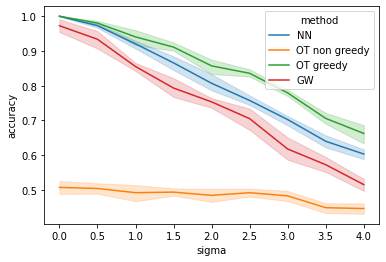

In [380]:
import seaborn as sns

sns.lineplot(data=res, x="sigma", y="accuracy", hue="method")

In [369]:
res_NEON_gmn = pd.read_csv('NEON/results/evaluation_gmn.csv')
res_NEON = pd.concat([res, res_NEON_gmn])

<AxesSubplot:title={'center':'Evaluation of Mapping Methods when Increasing Noise in GPS on a Synthetic Dataset\n (3839 trees of NEON Dataset)'}, xlabel='sigma (m)', ylabel='accuracy'>

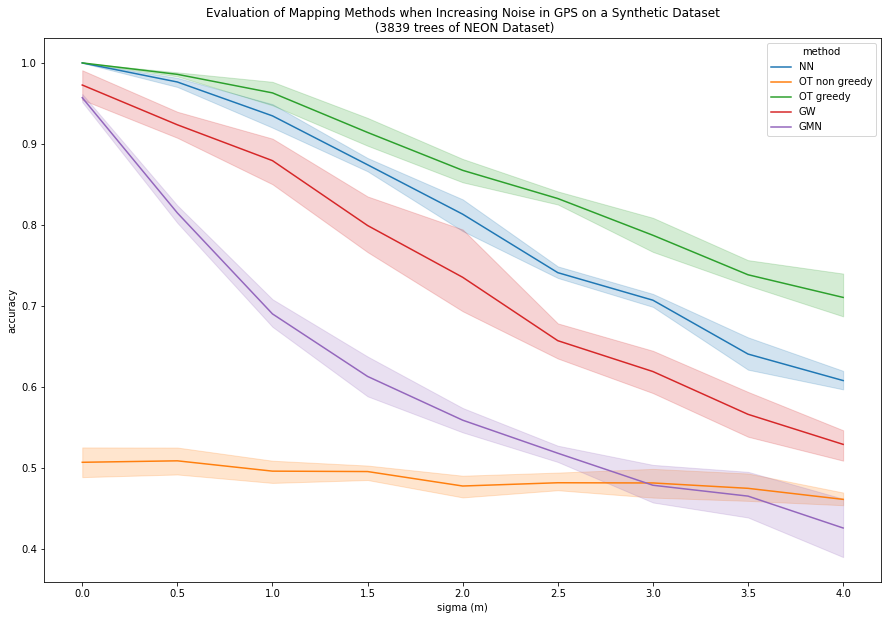

In [371]:
fig, ax = plt.subplots(figsize=[15, 10])
ax.set_xlabel('sigma (m)')
ax.set_ylabel('accuracy')
ax.set_title('Evaluation of Mapping Methods when Increasing Noise in GPS on a Synthetic Dataset\n (3839 trees of NEON Dataset)')

sns.lineplot(data=res_NEON, x="sigma", y="accuracy", hue="method", ax=ax)